In [10]:
# Install required packages
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn missingno

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import os

# Set visualization styles
# plt.style.use('seaborn-whitegrid')  # Removed incorrect Matplotlib style
sns.set_theme(style="whitegrid", palette="muted", color_codes=True) # Use Seaborn's set_theme for styling

# Mount Google Drive to access files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Define paths to the data folders
macro_folder = '/content/drive/MyDrive/processed_data'
financial_folder = '/content/drive/MyDrive/financial_info'

# Create a function to load macro data and handle redundant columns
def load_and_clean_macro_data(country_name):
    file_path = f"{macro_folder}/{country_name}_macro.csv"
    print(f"Loading {country_name} macro data...")

    # Read the data
    df = pd.read_csv(file_path, parse_dates=['date'])

    # Initial shape
    print(f"Original shape: {df.shape}")

    # Identify unique base column names (without _x or _y suffixes)
    base_columns = set()
    for col in df.columns:
        if col == 'date':
            continue
        base_name = col.split('_')[0]
        base_columns.add(base_name)

    print(f"Identified unique indicators: {base_columns}")

    # Create a clean DataFrame with only one column per indicator
    clean_df = pd.DataFrame()
    clean_df['date'] = df['date']

    # For each base column, keep only one version (prioritize non-suffixed version)
    for base_col in base_columns:
        if base_col in df.columns:
            clean_df[base_col] = df[base_col]
        elif f"{base_col}_x" in df.columns:
            clean_df[base_col] = df[f"{base_col}_x"]
        elif f"{base_col}_y" in df.columns:
            clean_df[base_col] = df[f"{base_col}_y"]

    print(f"Cleaned shape: {clean_df.shape}")
    return clean_df

# Load financial data
def load_financial_data(country_name):
    file_path = f"{financial_folder}/{country_name}_stock.csv"
    print(f"Loading {country_name} financial data...")

    # Read the data
    df = pd.read_csv(file_path)

    # Some files might have 'Date' or 'date' column
    date_col = 'Date' if 'Date' in df.columns else 'date'

    # Convert date to datetime
    df[date_col] = pd.to_datetime(df[date_col])

    # Some files might have 'Close' or 'close' column
    close_col = 'Close' if 'Close' in df.columns else 'close'

    # Keep only date and close price
    stock_df = df[[date_col, close_col]].copy()
    stock_df.columns = ['date', 'close']

    print(f"Stock data shape: {stock_df.shape}")
    return stock_df

# Load data for each country
brazil_macro = load_and_clean_macro_data('Brazil')
india_macro = load_and_clean_macro_data('India')
sa_macro = load_and_clean_macro_data('South_Africa')

brazil_stock = load_financial_data('brazil')
india_stock = load_financial_data('india')
sa_stock = load_financial_data('south_africa')


Loading Brazil macro data...
Original shape: (52, 19)
Identified unique indicators: {'IMPORTS', 'EXCHANGE', 'GDP', 'CPI', 'EXPORTS', 'INTEREST'}
Cleaned shape: (52, 5)
Loading India macro data...
Original shape: (52, 19)
Identified unique indicators: {'IMPORTS', 'EXCHANGE', 'GDP', 'CPI', 'EXPORTS', 'INTEREST'}
Cleaned shape: (52, 5)
Loading South_Africa macro data...
Original shape: (52, 25)
Identified unique indicators: {'IMPORTS', 'EXCHANGE', 'GDP', 'CPI', 'BOND', 'EXPORTS', 'UNEMPLOYMENT', 'INTEREST'}
Cleaned shape: (52, 6)
Loading brazil financial data...
Stock data shape: (149, 2)
Loading india financial data...
Stock data shape: (149, 2)
Loading south_africa financial data...
Stock data shape: (149, 2)



--- Missing Value Analysis for Brazil ---

Columns with missing values:
         Missing Count  Missing Percent
GDP                  6        11.538462
CPI                  4         7.692308
IMPORTS              2         3.846154
EXPORTS              2         3.846154


<Figure size 1000x600 with 0 Axes>

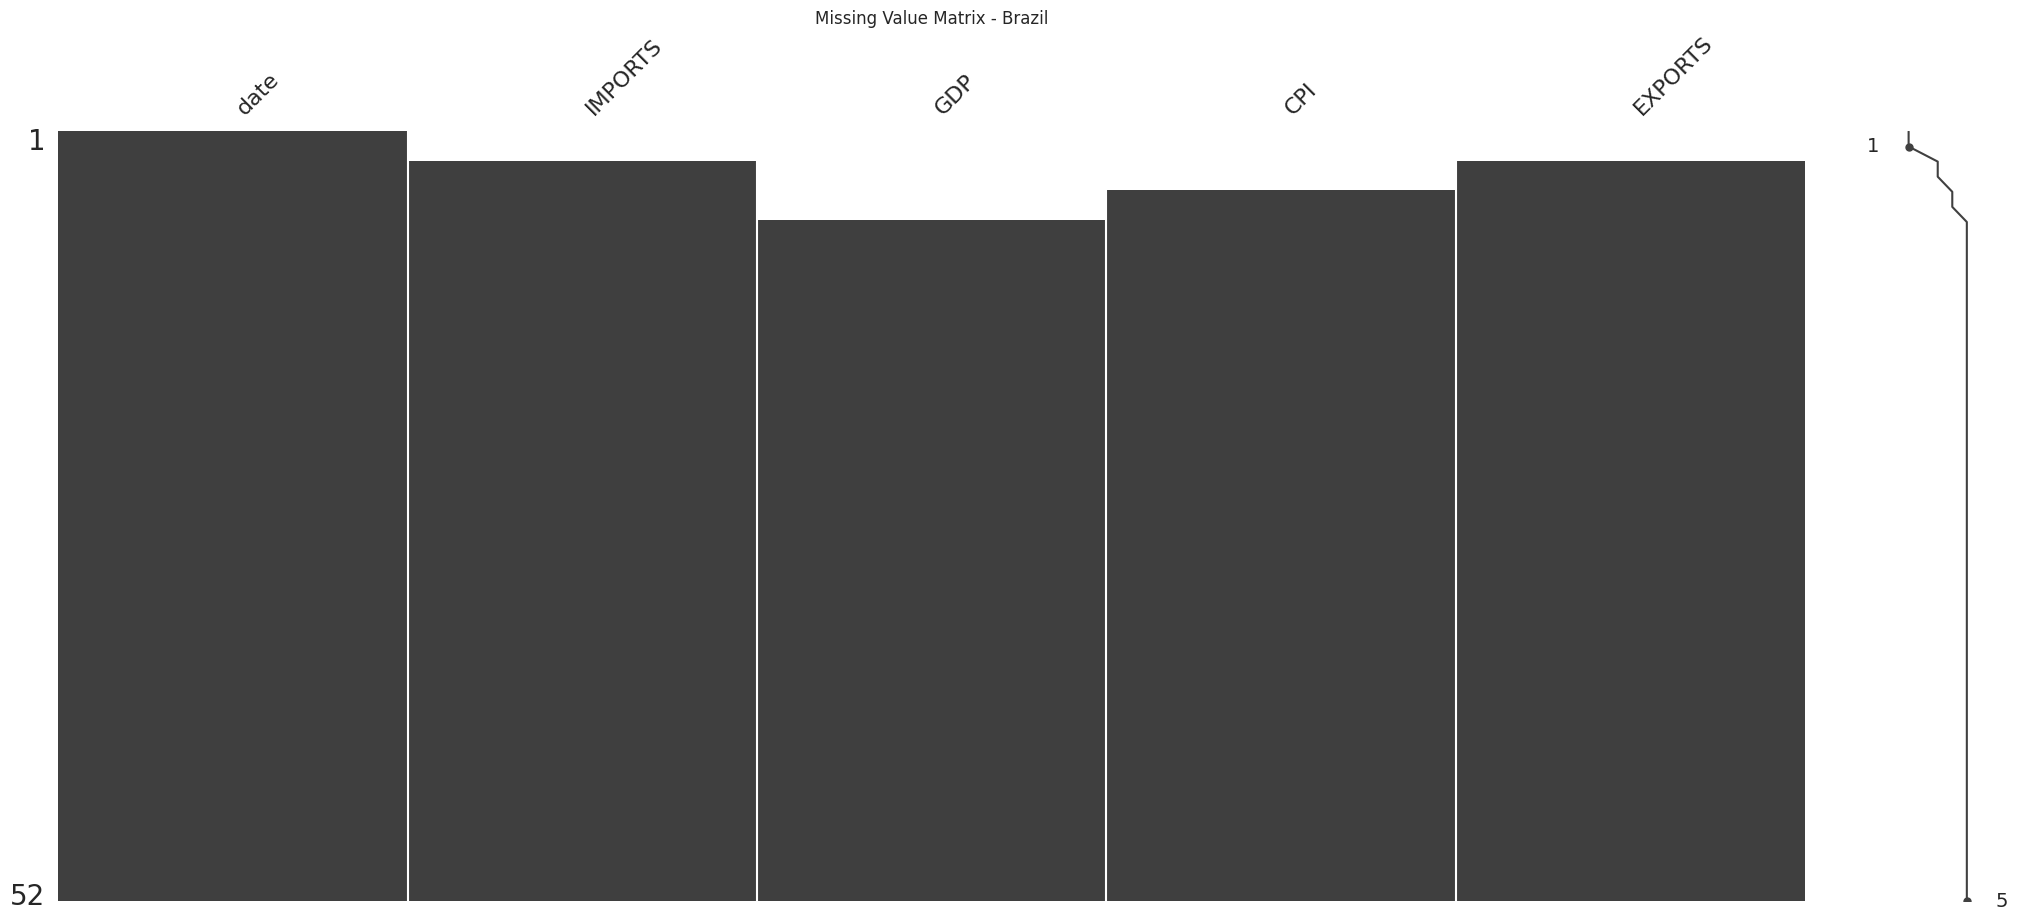

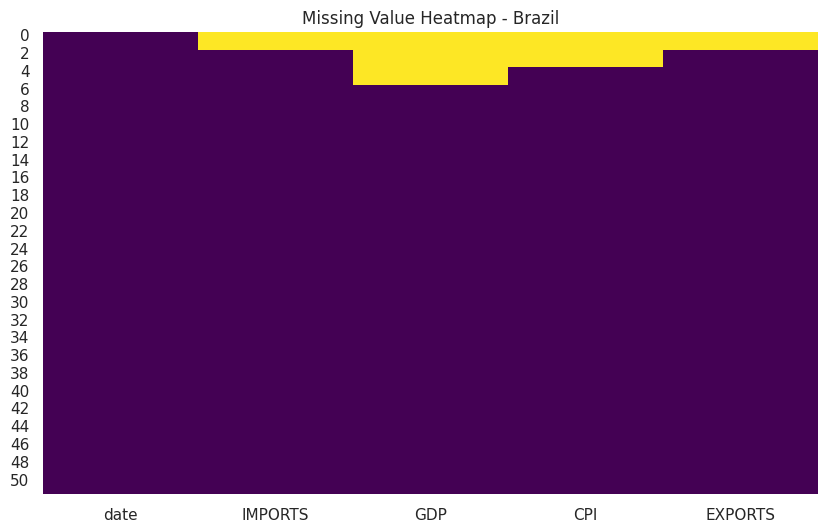


--- Missing Value Analysis for India ---

Columns with missing values:
         Missing Count  Missing Percent
GDP                  7        13.461538
CPI                  7        13.461538
IMPORTS              2         3.846154
EXPORTS              2         3.846154


<Figure size 1000x600 with 0 Axes>

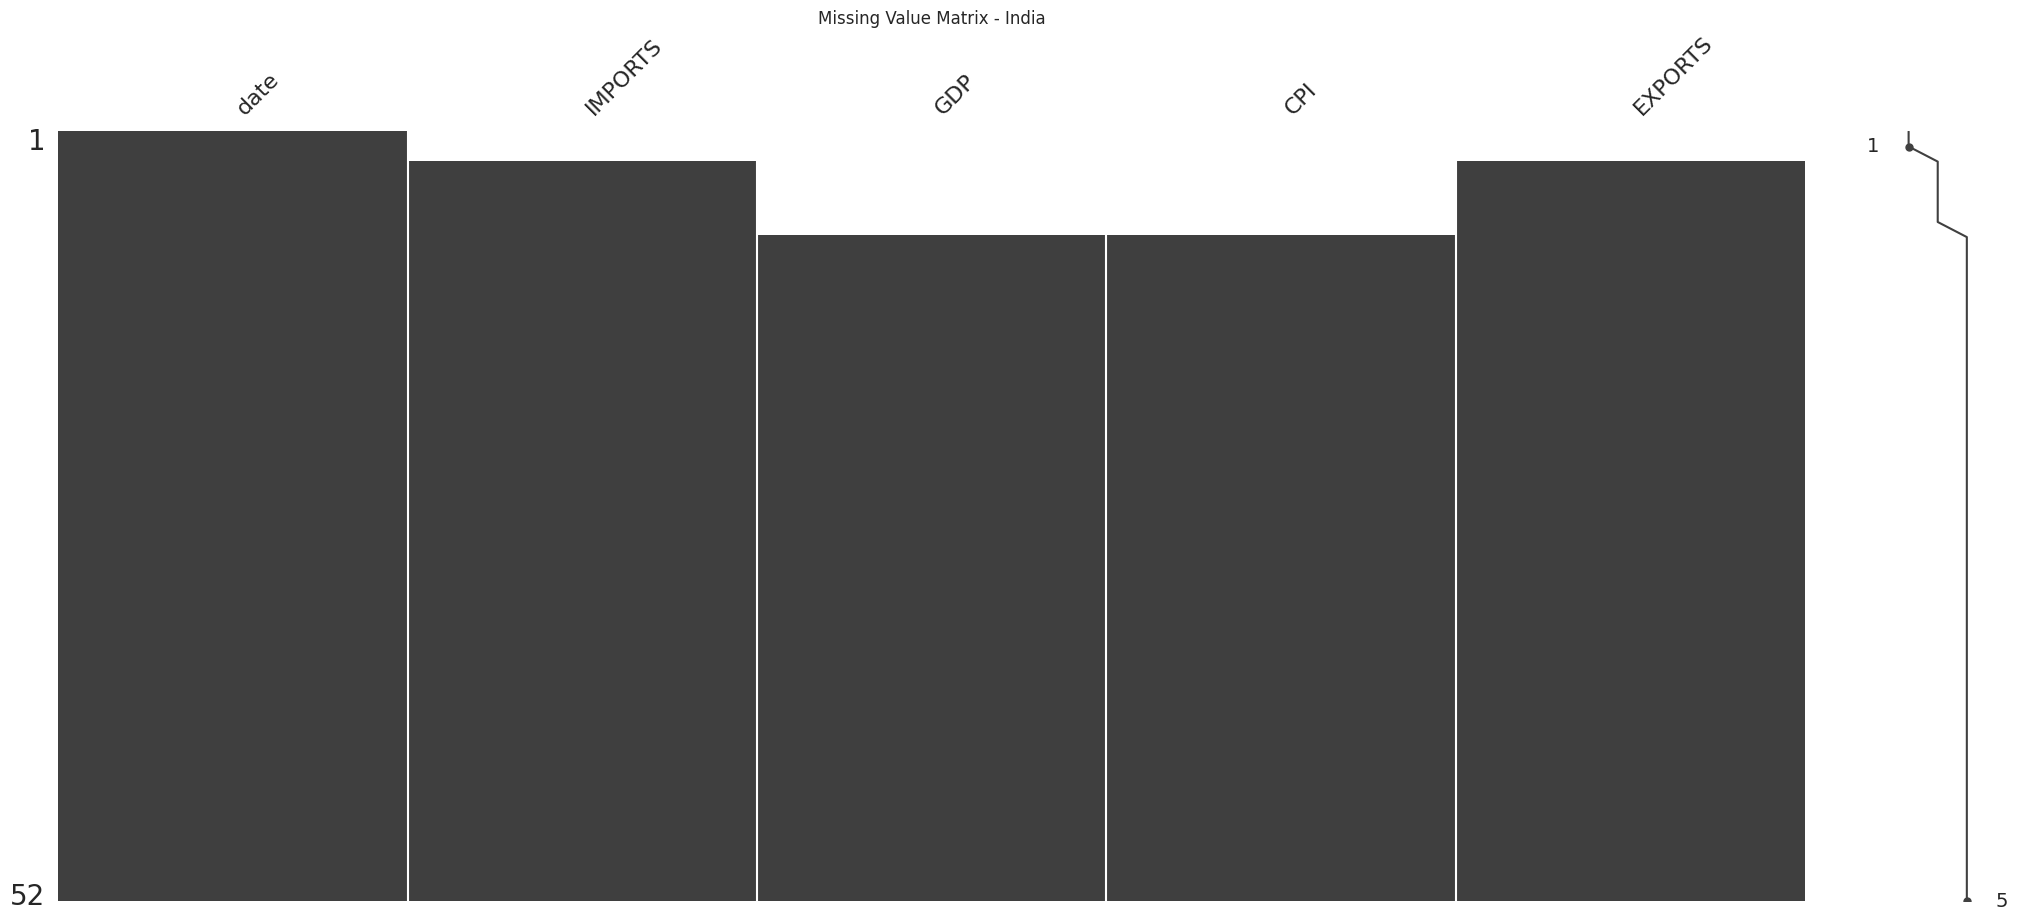

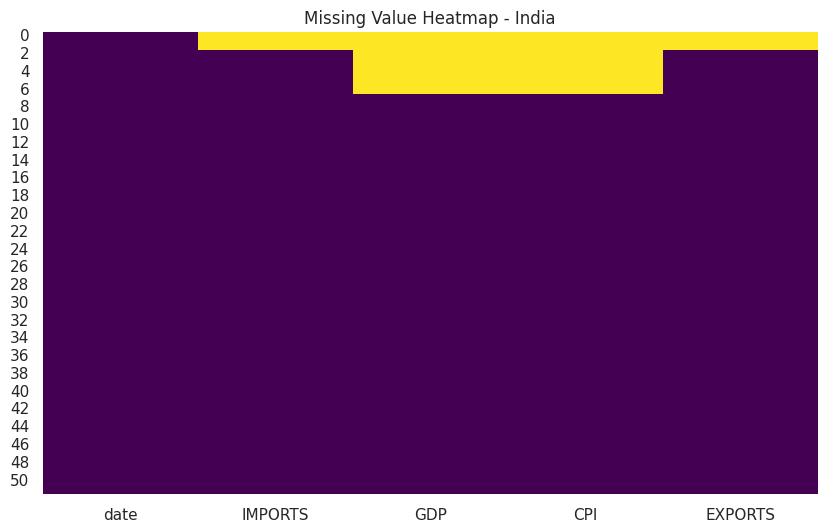


--- Missing Value Analysis for South Africa ---

Columns with missing values:
              Missing Count  Missing Percent
GDP                       7        13.461538
UNEMPLOYMENT              7        13.461538
CPI                       3         5.769231
IMPORTS                   2         3.846154
EXPORTS                   2         3.846154


<Figure size 1000x600 with 0 Axes>

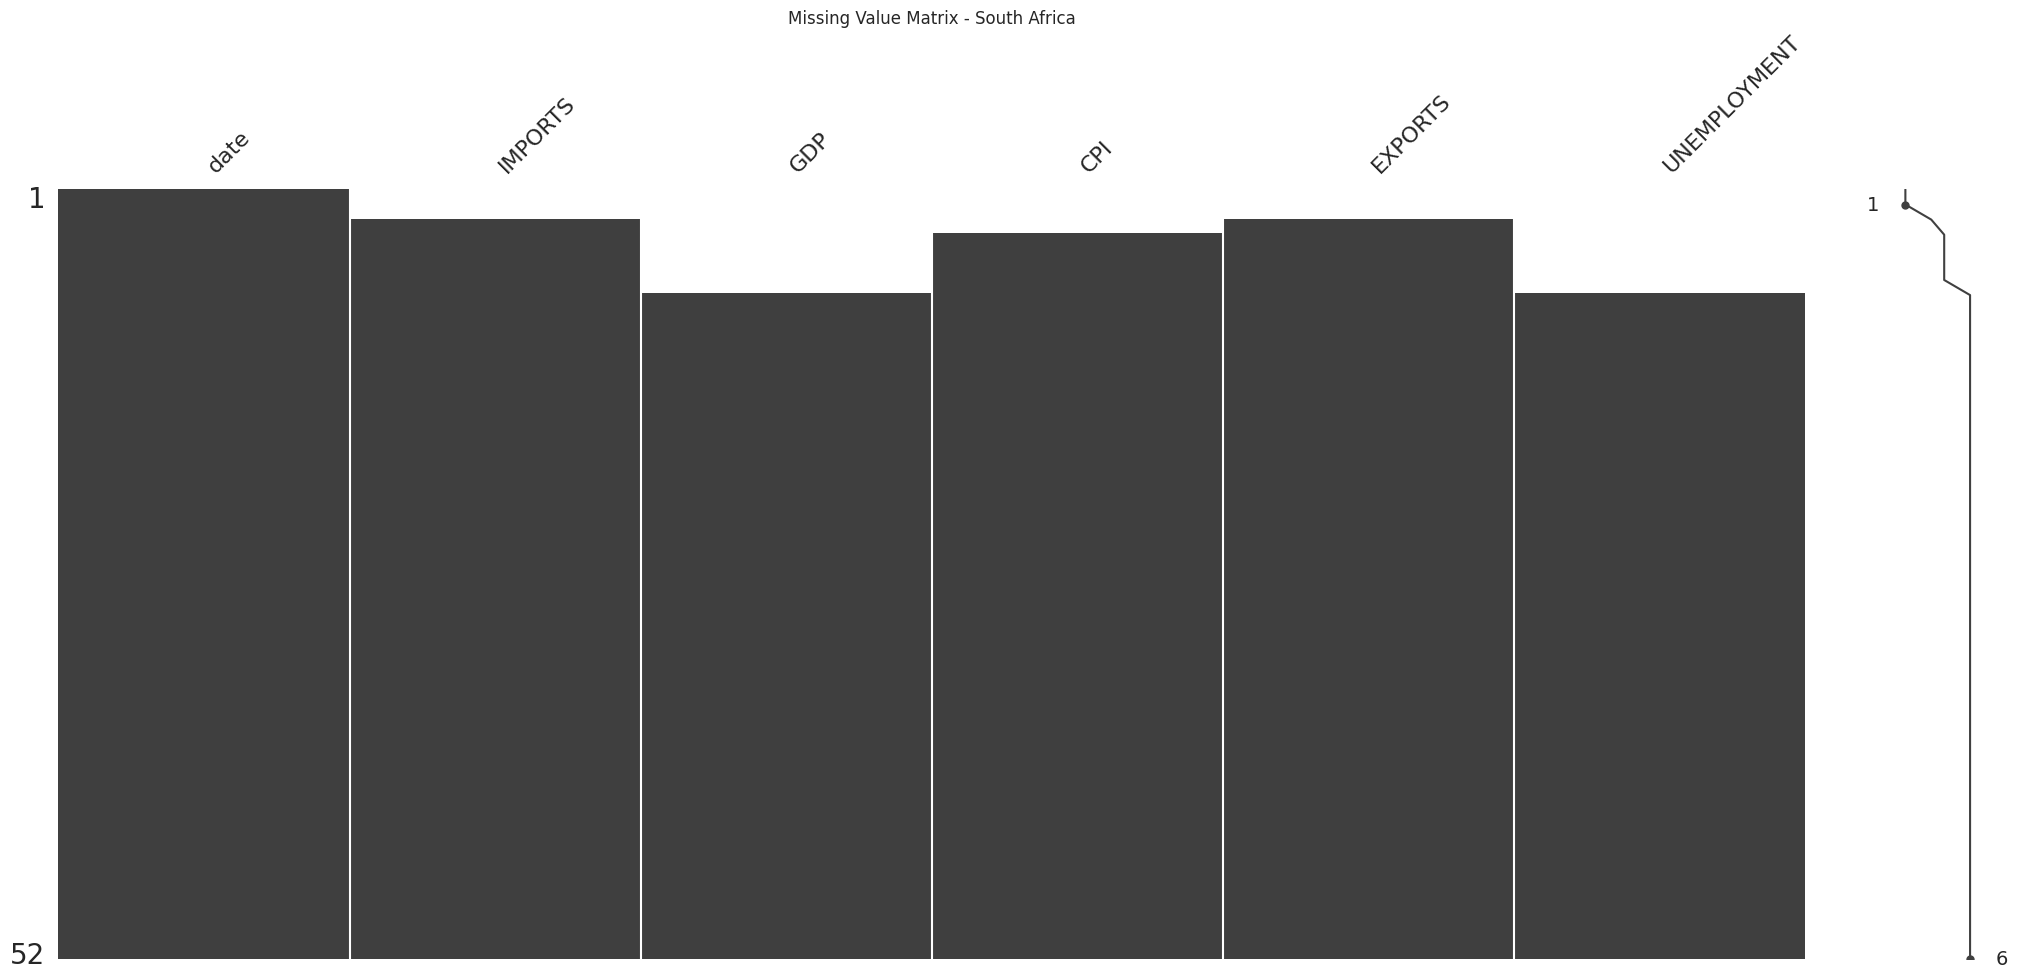

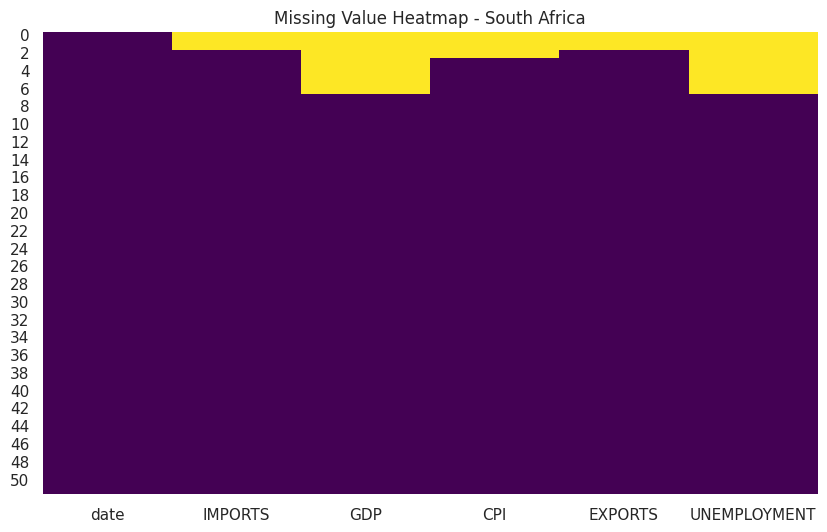

In [14]:
def analyze_missing_values(df, country_name):
    """Analyze and visualize missing values in the dataset"""
    print(f"\n--- Missing Value Analysis for {country_name} ---")

    # Calculate missing values
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_data = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percent': missing_percent
    })
    missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False)

    if len(missing_data) > 0:
        print("\nColumns with missing values:")
        print(missing_data)

        # Visualize missing values
        plt.figure(figsize=(10, 6))
        msno.matrix(df)
        plt.title(f'Missing Value Matrix - {country_name}')
        plt.show()

        # Missing value heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
        plt.title(f'Missing Value Heatmap - {country_name}')
        plt.show()
    else:
        print("No missing values found!")

    return missing_data

# Analyze missing values for each country
brazil_missing = analyze_missing_values(brazil_macro, "Brazil")
india_missing = analyze_missing_values(india_macro, "India")
sa_missing = analyze_missing_values(sa_macro, "South Africa")


In [27]:
def clean_and_merge_data(macro_df, stock_df, country_name):
    """Clean and merge macro and stock data"""
    # Handle case sensitivity in stock dataframe column names
    date_col = 'Date' if 'Date' in stock_df.columns else 'date'
    close_col = 'Close' if 'Close' in stock_df.columns else 'close'

    # Create a copy with standardized column names
    stock_df_copy = stock_df.copy()
    stock_df_copy.rename(columns={date_col: 'date', close_col: 'close'}, inplace=True)

    # Convert date to datetime and remove timezone information
    macro_df['date'] = pd.to_datetime(macro_df['date']).dt.tz_localize(None)
    stock_df_copy['date'] = pd.to_datetime(stock_df_copy['date']).dt.tz_localize(None)

    # If stock data has daily frequency, resample to quarterly
    if len(stock_df_copy) > len(macro_df):
        print(f"Resampling {country_name} stock data to quarterly frequency...")
        # Convert to quarter end dates
        stock_df_copy['quarter_end'] = pd.PeriodIndex(stock_df_copy['date'], freq='Q').to_timestamp(how='end')
        quarterly_stock = stock_df_copy.groupby('quarter_end').agg({'close': 'last'})
        quarterly_stock.reset_index(inplace=True)
    else:
        quarterly_stock = stock_df_copy.rename(columns={'date': 'quarter_end'})

    # Convert macro dates to quarter end dates for consistency
    macro_df['quarter_end'] = pd.PeriodIndex(macro_df['date'], freq='Q').to_timestamp(how='end')

    # Print date ranges for debugging
    print(f"Stock data date range: {quarterly_stock['quarter_end'].min()} to {quarterly_stock['quarter_end'].max()}")
    print(f"Macro data date range: {macro_df['quarter_end'].min()} to {macro_df['quarter_end'].max()}")

    # Forward fill missing values in macro data
    macro_df_filled = macro_df.ffill()

    # Merge macro and stock data on the quarter-end dates
    merged_df = pd.merge(
        quarterly_stock,
        macro_df_filled,
        on='quarter_end',
        how='inner'
    )

    print(f"Merged data shape for {country_name}: {merged_df.shape}")

    # Set quarter_end as index and drop the date column that might be present
    if not merged_df.empty:
        if 'date' in merged_df.columns:
            merged_df.drop('date', axis=1, inplace=True)
        merged_df.set_index('quarter_end', inplace=True)

    return merged_df


brazil_data = clean_and_merge_data(brazil_macro, brazil_stock, "Brazil")
india_data = clean_and_merge_data(india_macro, india_stock, "India")
sa_data = clean_and_merge_data(sa_macro, sa_stock, "South Africa")

print("Merged Data for Brazil:")  # Added for clarity
print(brazil_data)

print("Merged Data for India:")  # Added for clarity
print(india_data)

print("Merged Data for South Africa:")  # Added for clarity
print(sa_data)

Resampling Brazil stock data to quarterly frequency...
Stock data date range: 2013-03-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Macro data date range: 2013-03-31 23:59:59.999999999 to 2025-12-31 23:59:59.999999999
Merged data shape for Brazil: (50, 7)
Resampling India stock data to quarterly frequency...
Stock data date range: 2013-03-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Macro data date range: 2013-03-31 23:59:59.999999999 to 2025-12-31 23:59:59.999999999
Merged data shape for India: (50, 7)
Resampling South Africa stock data to quarterly frequency...
Stock data date range: 2013-03-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Macro data date range: 2013-03-31 23:59:59.999999999 to 2025-12-31 23:59:59.999999999
Merged data shape for South Africa: (50, 8)
Merged Data for Brazil:
                                   close    IMPORTS           GDP       CPI  \
quarter_end                                                                   
2013-03-31 23


--- Descriptive Statistics for Brazil ---

Key statistics:
                  mean           std            min            max  \
IMPORTS      10.291525      1.872830       7.190162      14.849162   
GDP      306421.911222  16312.648657  270496.500000  337356.312500   
CPI           1.463295      0.884123      -0.417887       3.222384   
EXPORTS      12.867049      2.835159       8.745587      18.101351   

                range   coef_var  
IMPORTS      7.659000  18.197786  
GDP      66859.812500   5.323591  
CPI          3.640271  60.419991  
EXPORTS      9.355764  22.034259  


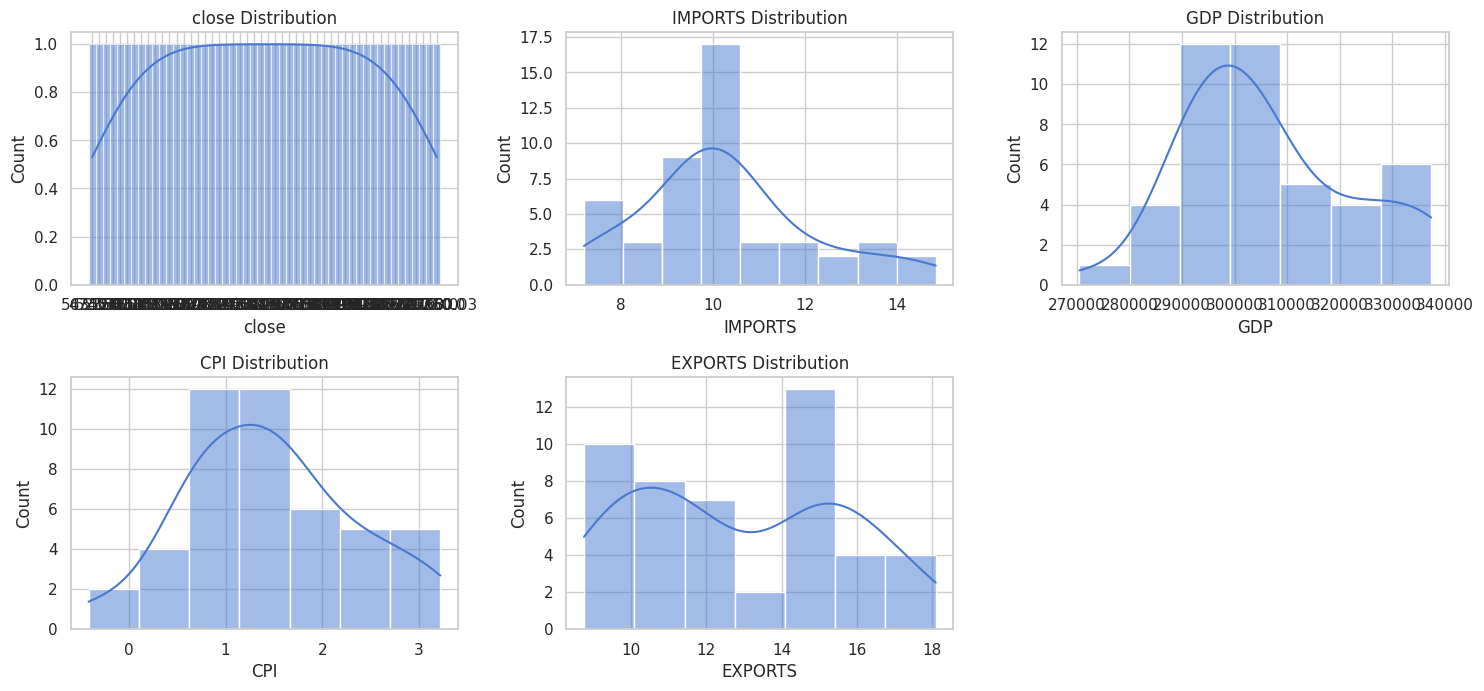

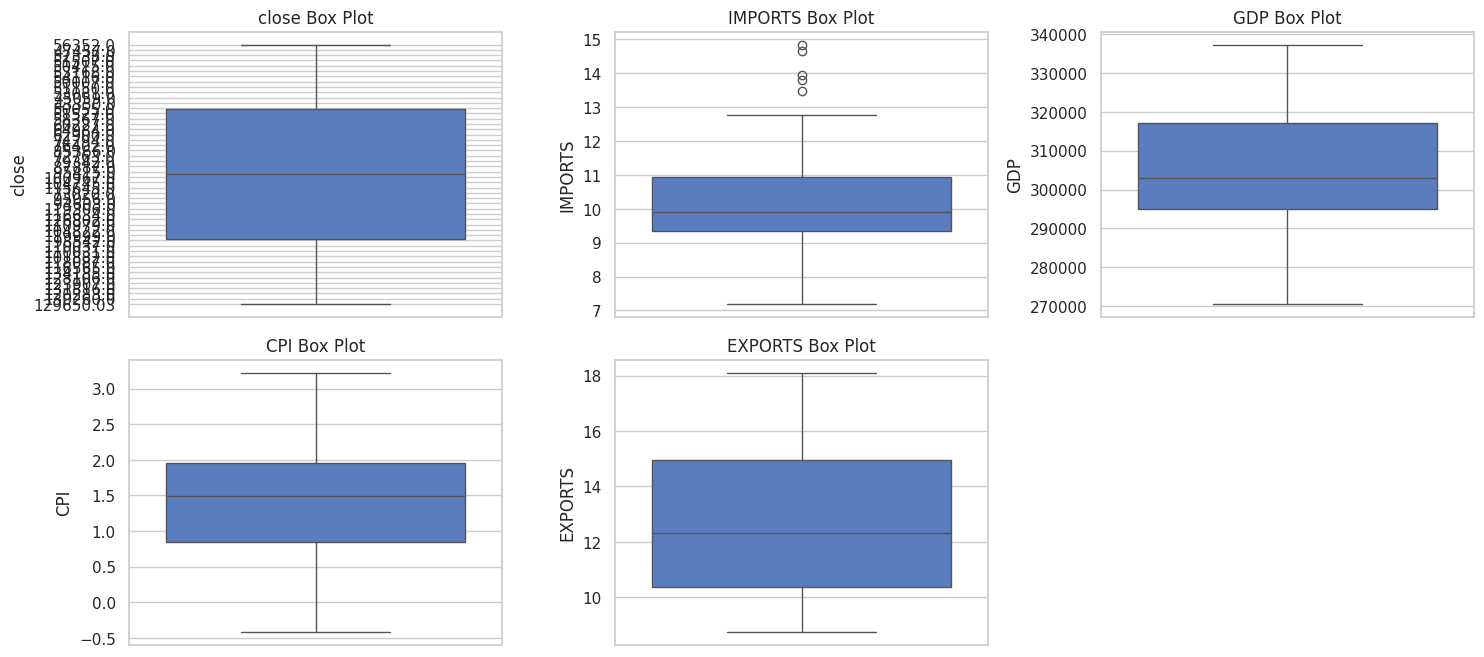


--- Descriptive Statistics for India ---

Key statistics:
                 mean           std           min           max         range  \
IMPORTS  1.875934e+01  2.575195e+00  1.201005e+01  2.450113e+01  1.249108e+01   
GDP      3.637139e+07  6.194805e+06  2.645950e+07  4.782030e+07  2.136080e+07   
CPI      1.266617e+02  2.023223e+01  9.678036e+01  1.589105e+02  6.213014e+01   
EXPORTS  1.271350e+01  1.759784e+00  1.012627e+01  1.821170e+01  8.085429e+00   

          coef_var  
IMPORTS  13.727537  
GDP      17.032084  
CPI      15.973432  
EXPORTS  13.841854  


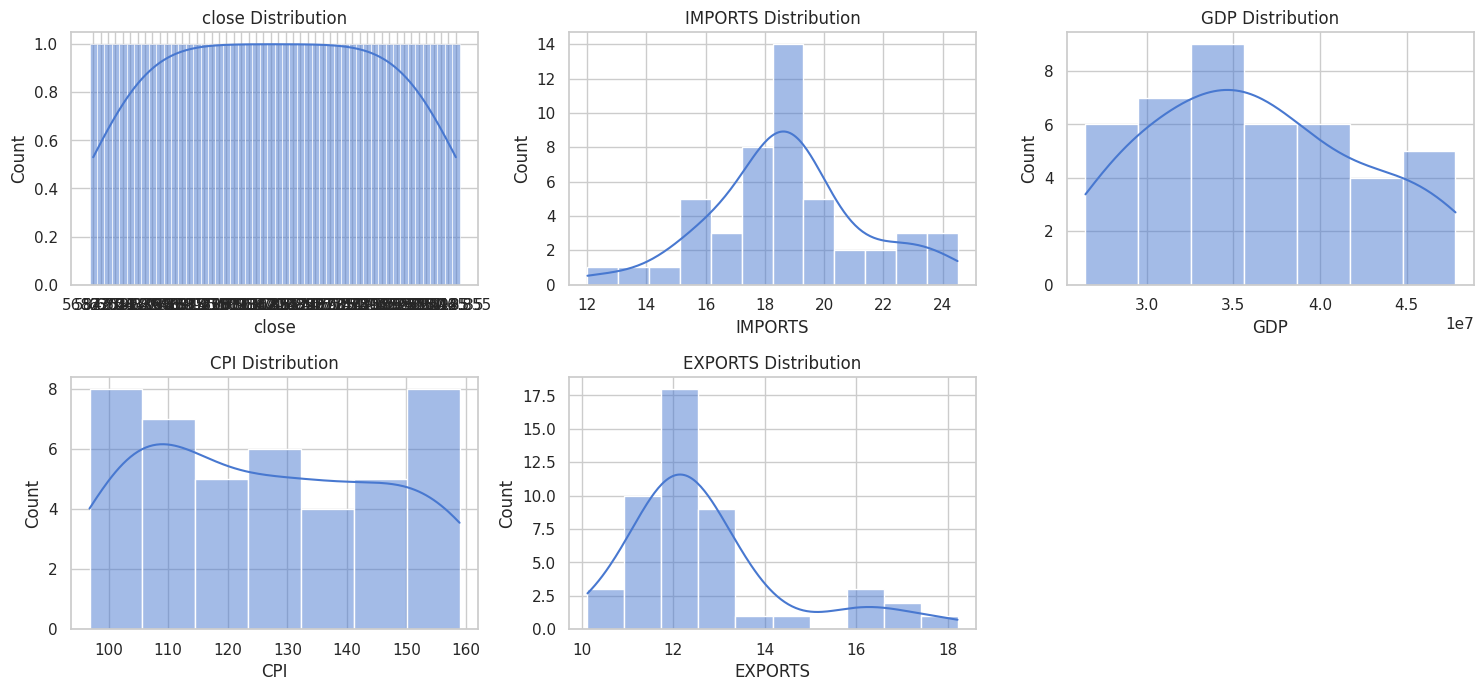

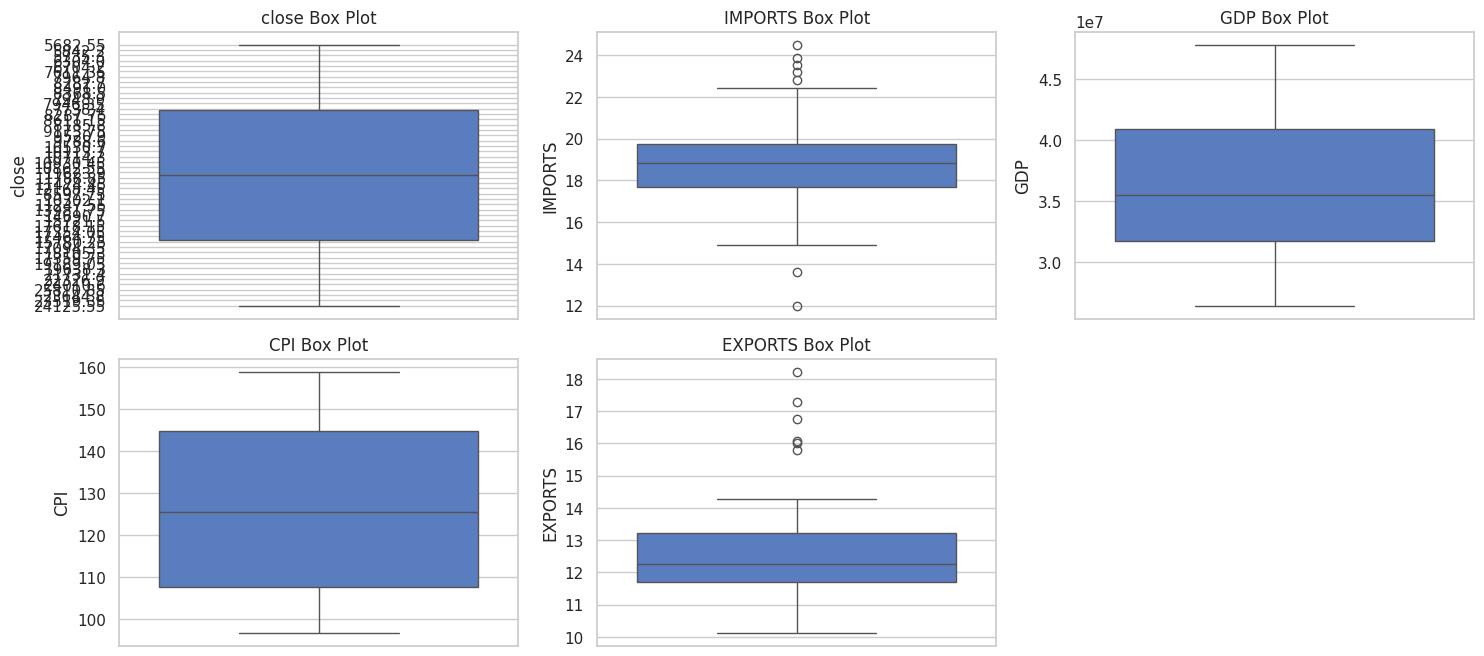


--- Descriptive Statistics for South Africa ---

Key statistics:
                      mean            std           min           max  \
IMPORTS       2.444376e+01       2.691228  1.907181e+01  3.026068e+01   
GDP           1.131985e+06   35704.496228  9.538462e+05  1.169859e+06   
CPI           1.292086e+00       0.601407 -2.521614e-01  2.806452e+00   
EXPORTS       2.590428e+01       3.079390  2.210177e+01  3.110838e+01   
UNEMPLOYMENT  3.312370e+06  529868.771717  2.144860e+06  4.120901e+06   

                     range   coef_var  
IMPORTS       1.118887e+01  11.009876  
GDP           2.160126e+05   3.154148  
CPI           3.058613e+00  46.545413  
EXPORTS       9.006606e+00  11.887572  
UNEMPLOYMENT  1.976041e+06  15.996665  


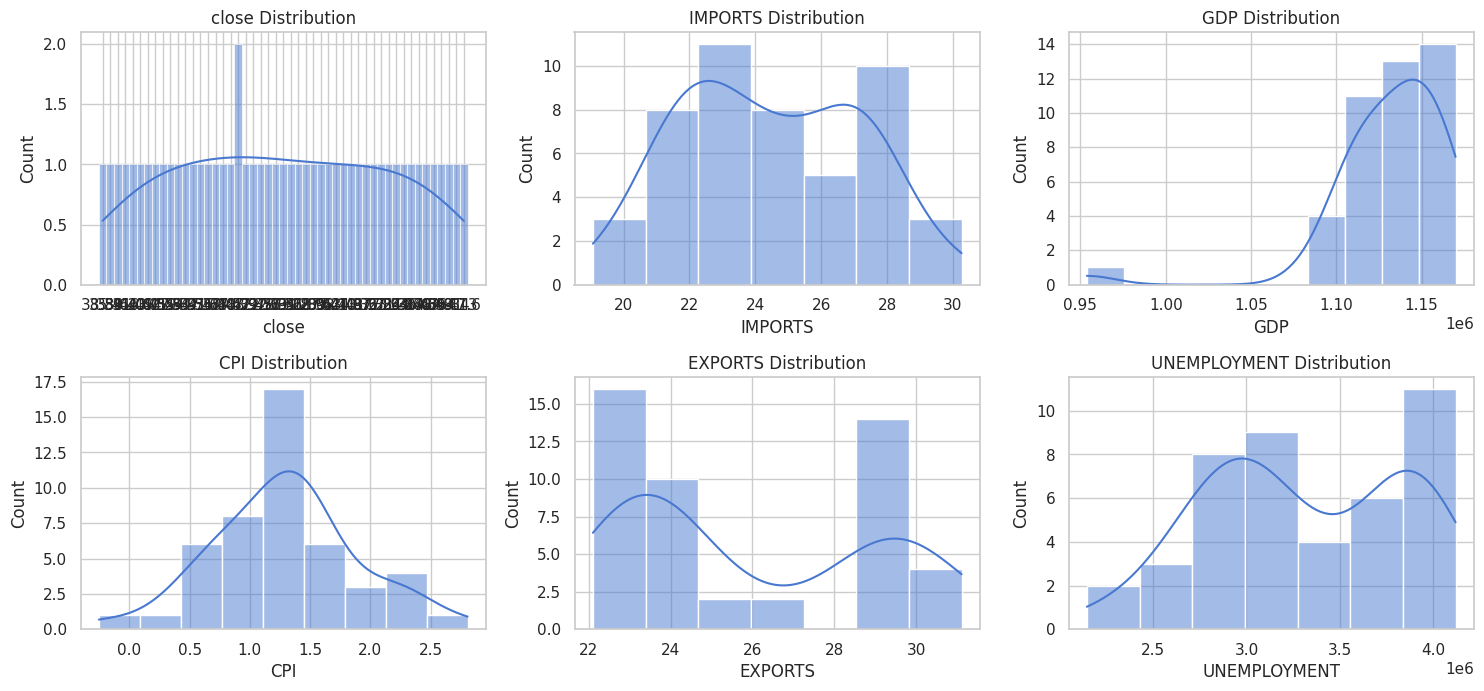

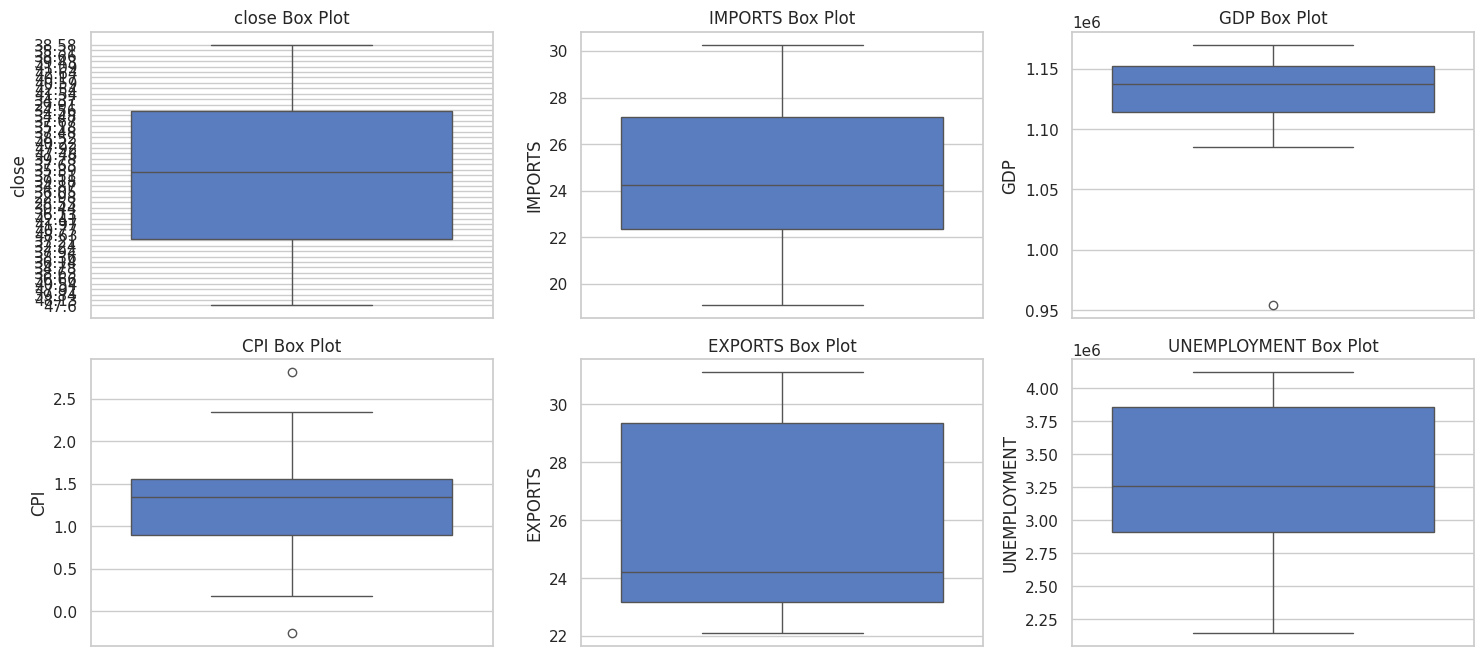

In [29]:
def compute_descriptive_stats(df, country_name):
    """Compute descriptive statistics for the dataset"""
    print(f"\n--- Descriptive Statistics for {country_name} ---")

    # Basic descriptive statistics
    desc_stats = df.describe().T

    # Add range and coefficient of variation
    desc_stats['range'] = desc_stats['max'] - desc_stats['min']
    desc_stats['coef_var'] = (desc_stats['std'] / desc_stats['mean']).abs() * 100

    print("\nKey statistics:")
    print(desc_stats[['mean', 'std', 'min', 'max', 'range', 'coef_var']])

    # Visualize distributions
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(df.columns):
        plt.subplot(3, 3, i+1)
        sns.histplot(df[column], kde=True)
        plt.title(f'{column} Distribution')
        plt.tight_layout()
    plt.show()

    # Box plots to identify outliers
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(df.columns):
        plt.subplot(3, 3, i+1)
        sns.boxplot(y=df[column])
        plt.title(f'{column} Box Plot')
        plt.tight_layout()
    plt.show()

    return desc_stats

# Compute descriptive statistics for each country
brazil_stats = compute_descriptive_stats(brazil_data, "Brazil")
india_stats = compute_descriptive_stats(india_data, "India")
sa_stats = compute_descriptive_stats(sa_data, "South Africa")



--- Correlation Analysis for Brazil ---


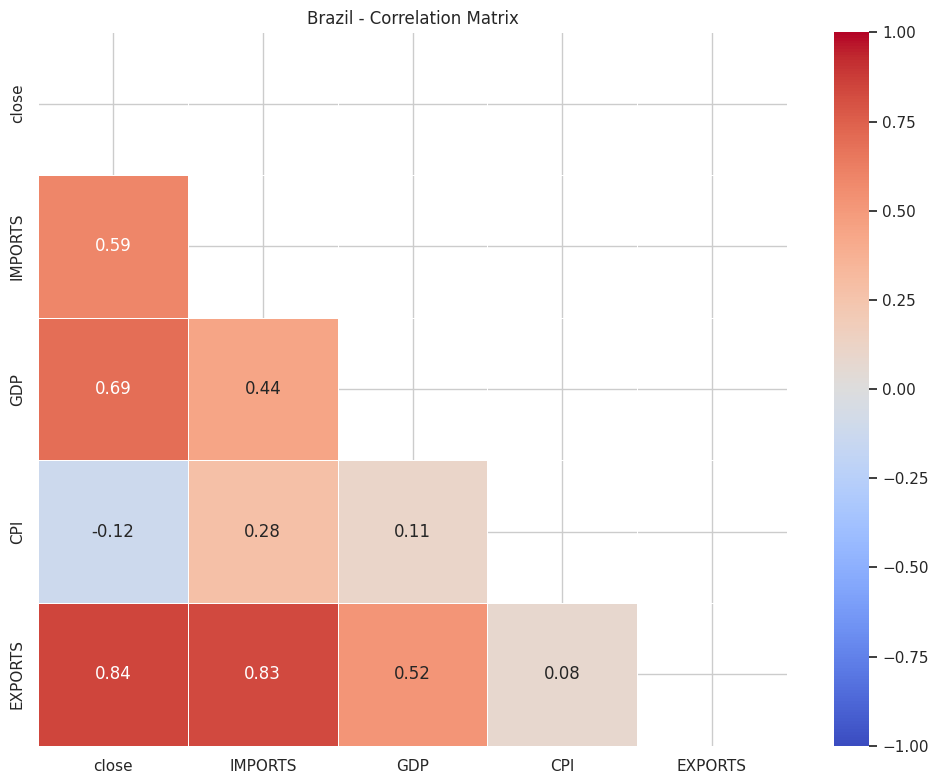

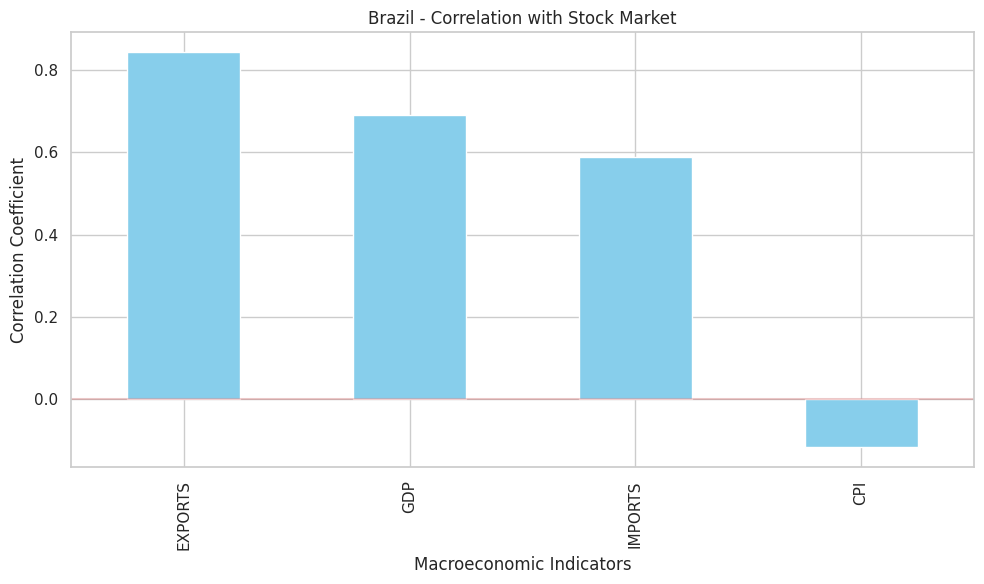


Highly correlated pairs (|correlation| > 0.7):
  • close and EXPORTS: 0.84
  • EXPORTS and close: 0.84
  • IMPORTS and EXPORTS: 0.83
  • EXPORTS and IMPORTS: 0.83

--- Correlation Analysis for India ---


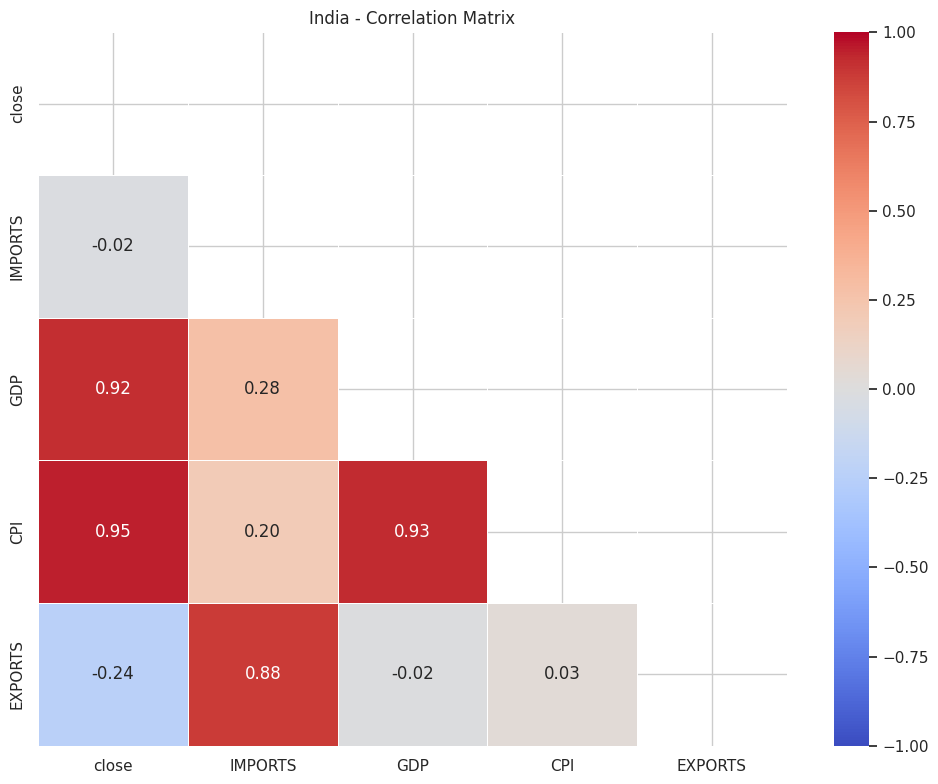

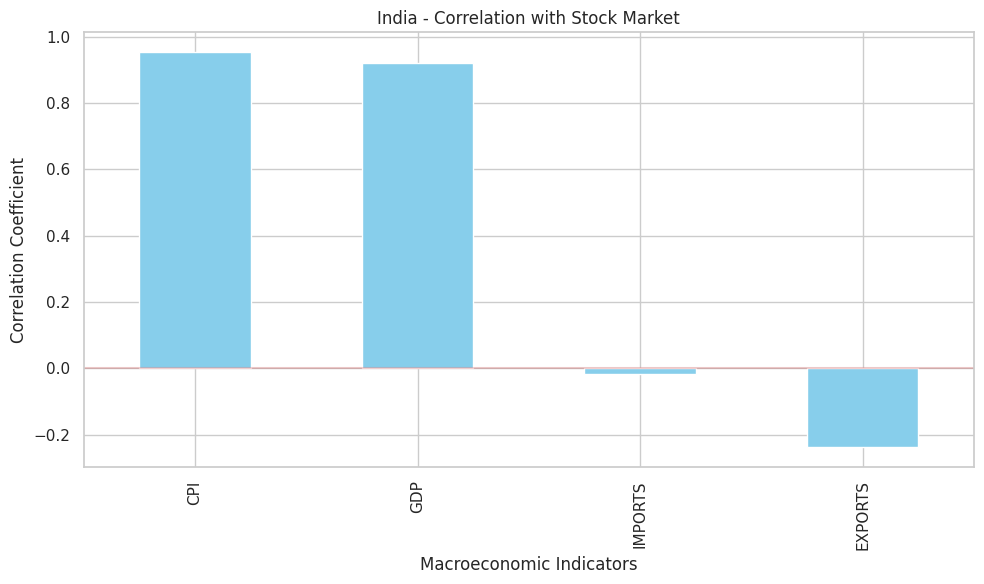


Highly correlated pairs (|correlation| > 0.7):
  • close and CPI: 0.95
  • CPI and close: 0.95
  • GDP and CPI: 0.93
  • CPI and GDP: 0.93
  • close and GDP: 0.92
  • GDP and close: 0.92
  • IMPORTS and EXPORTS: 0.88
  • EXPORTS and IMPORTS: 0.88

--- Correlation Analysis for South Africa ---


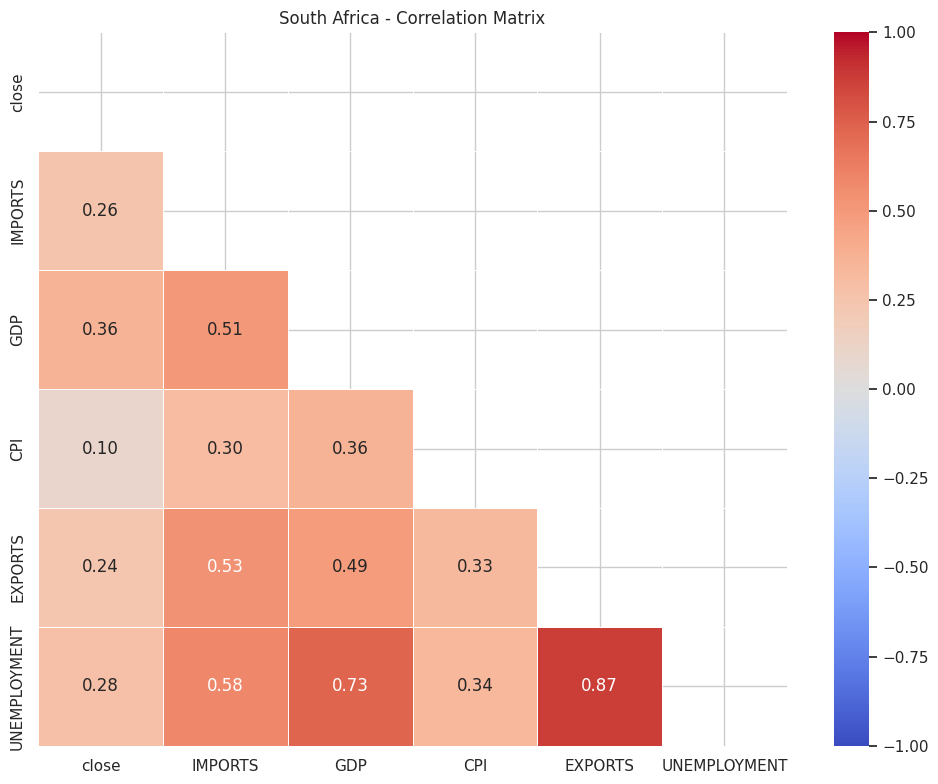

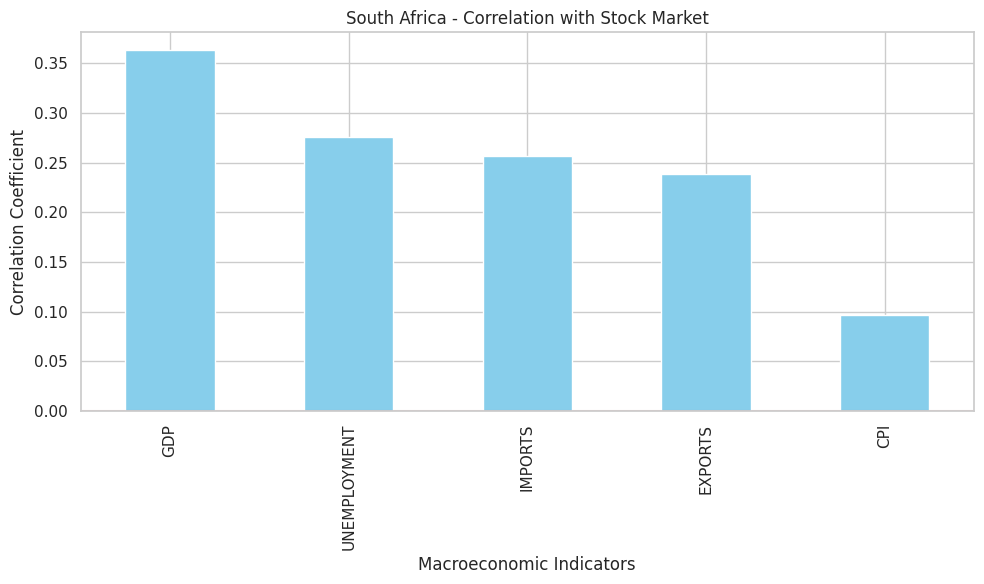


Highly correlated pairs (|correlation| > 0.7):
  • EXPORTS and UNEMPLOYMENT: 0.87
  • UNEMPLOYMENT and EXPORTS: 0.87
  • GDP and UNEMPLOYMENT: 0.73
  • UNEMPLOYMENT and GDP: 0.73


In [30]:
def perform_correlation_analysis(df, country_name):
    """Perform correlation analysis on the dataset"""
    print(f"\n--- Correlation Analysis for {country_name} ---")

    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        linewidths=0.5,
        mask=mask,
        vmin=-1,
        vmax=1,
        fmt=".2f"
    )
    plt.title(f'{country_name} - Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Extract correlations with stock price
    stock_corr = corr_matrix['close'].sort_values(ascending=False)

    # Create bar plot for stock correlations
    plt.figure(figsize=(10, 6))
    stock_corr.drop('close').plot(kind='bar', color='skyblue')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title(f'{country_name} - Correlation with Stock Market')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Macroeconomic Indicators')
    plt.tight_layout()
    plt.show()

    # Find highly correlated pairs
    corr_pairs = corr_matrix.unstack()
    high_corr = corr_pairs[((corr_pairs > 0.7) | (corr_pairs < -0.7)) & (corr_pairs != 1.0)]

    if not high_corr.empty:
        print("\nHighly correlated pairs (|correlation| > 0.7):")
        for idx, corr_value in high_corr.sort_values(ascending=False).items():
            print(f"  • {idx[0]} and {idx[1]}: {corr_value:.2f}")
    else:
        print("\nNo highly correlated pairs found.")

    return corr_matrix, stock_corr

# Perform correlation analysis for each country
brazil_corr, brazil_stock_corr = perform_correlation_analysis(brazil_data, "Brazil")
india_corr, india_stock_corr = perform_correlation_analysis(india_data, "India")
sa_corr, sa_stock_corr = perform_correlation_analysis(sa_data, "South Africa")



--- Time Series Visualization for Brazil ---


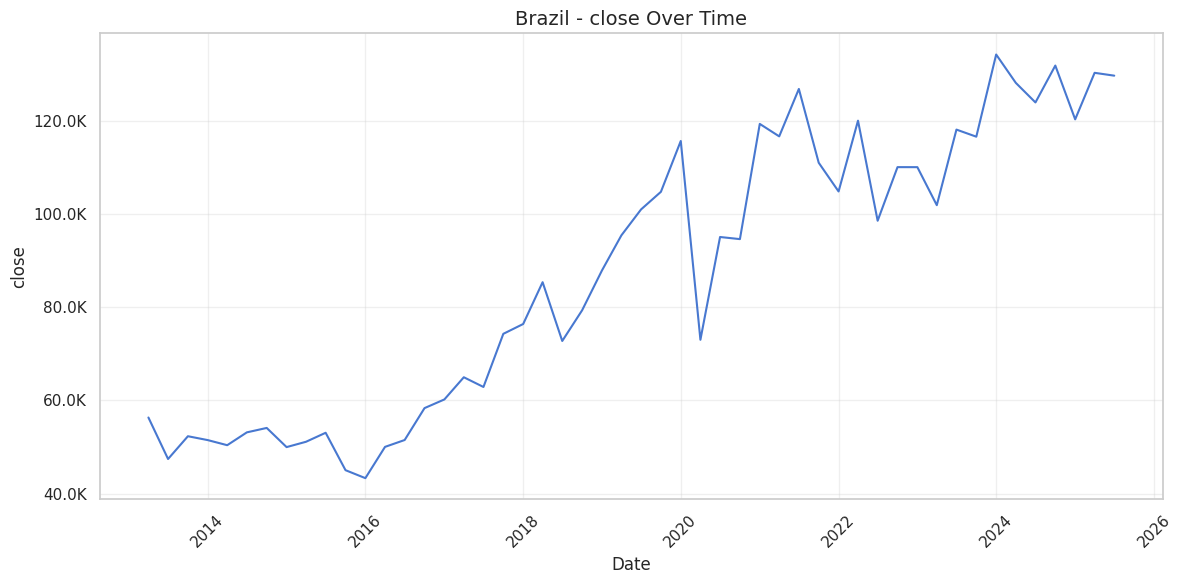

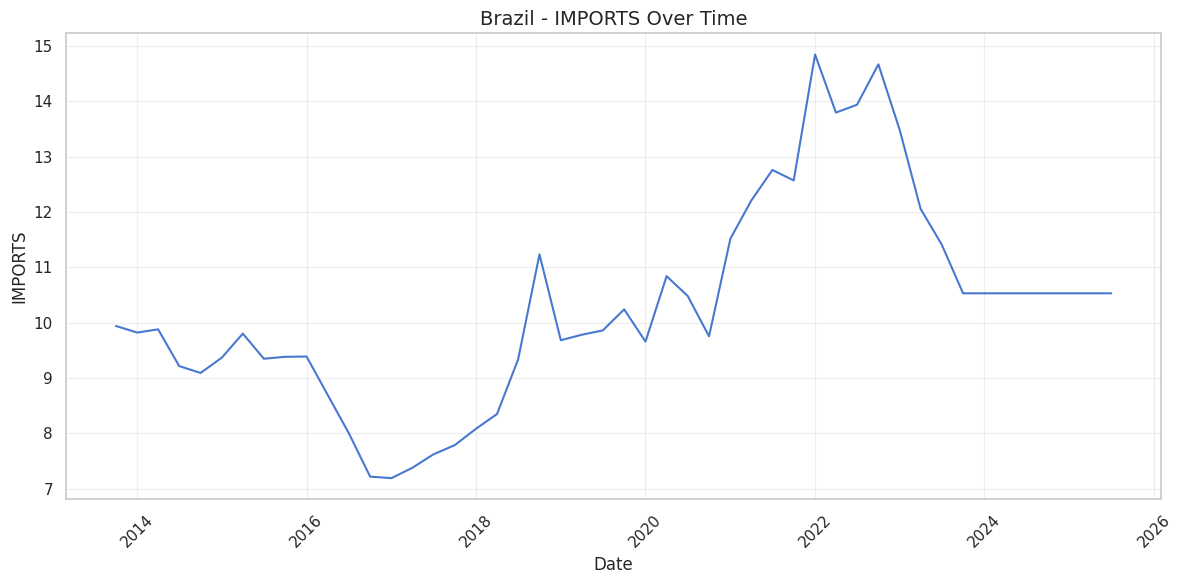

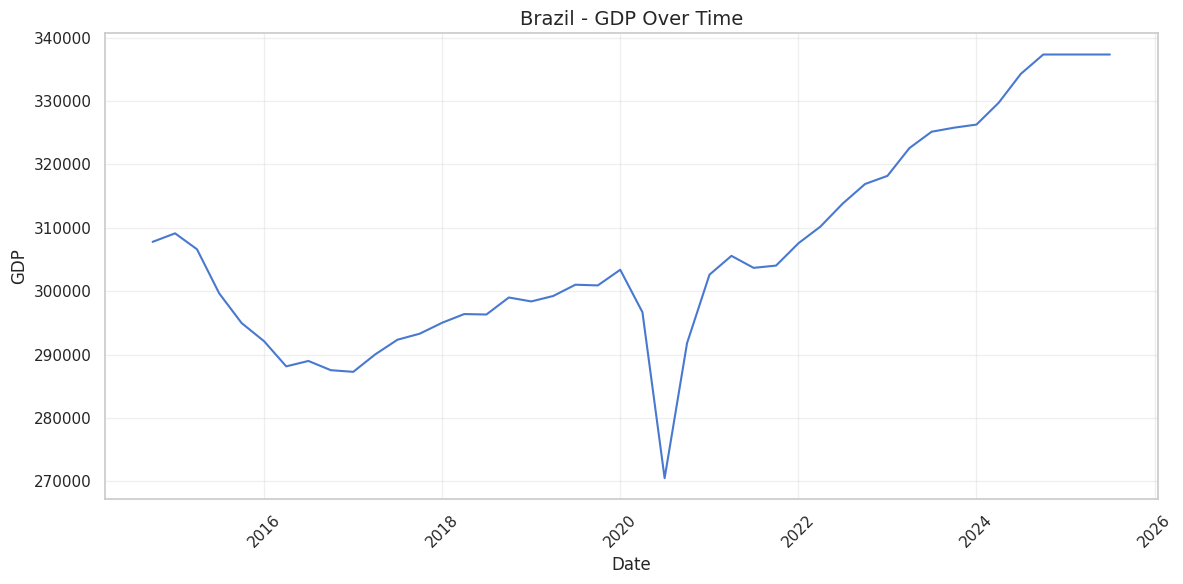

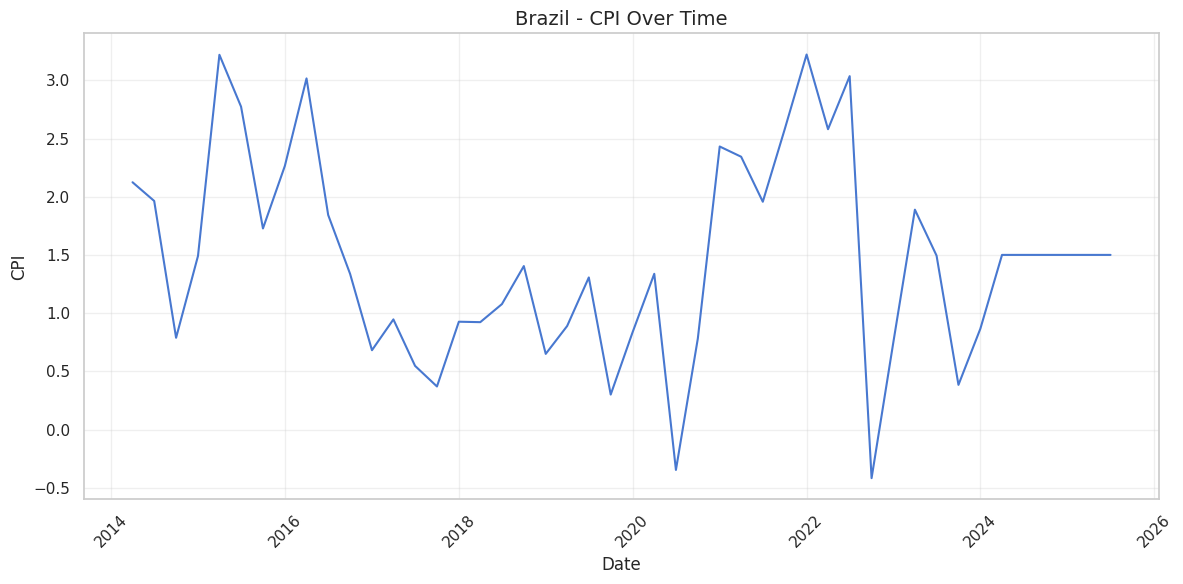

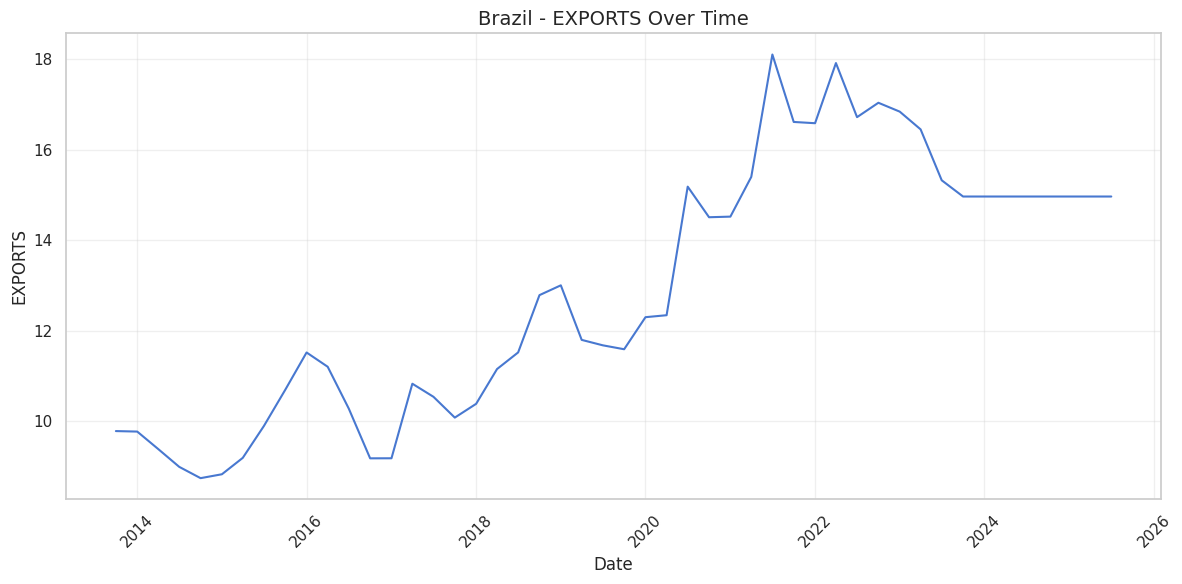


--- Time Series Visualization for India ---


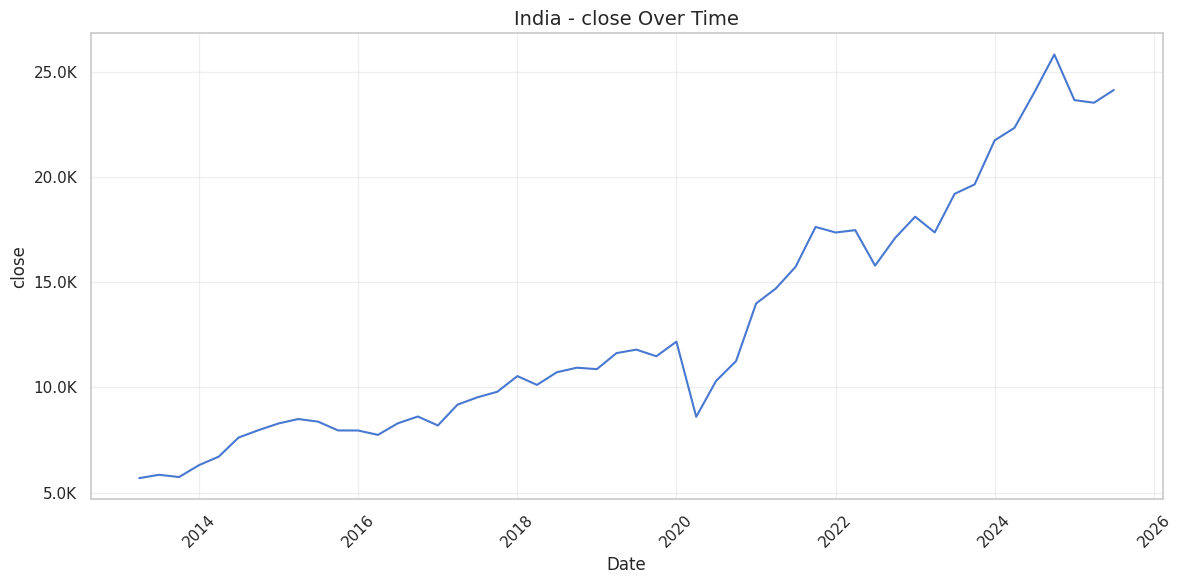

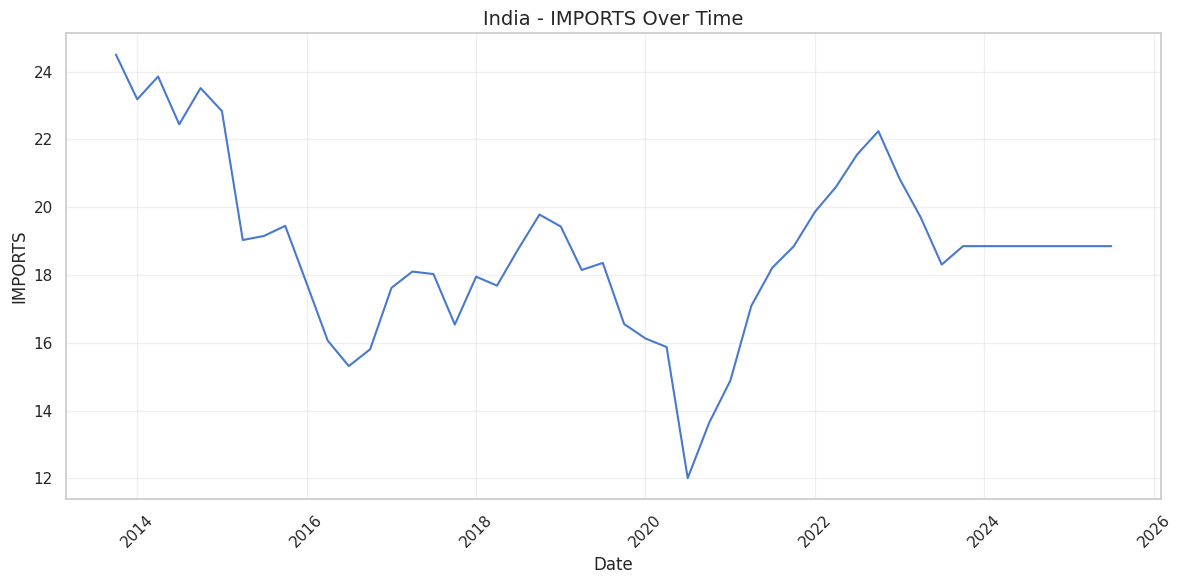

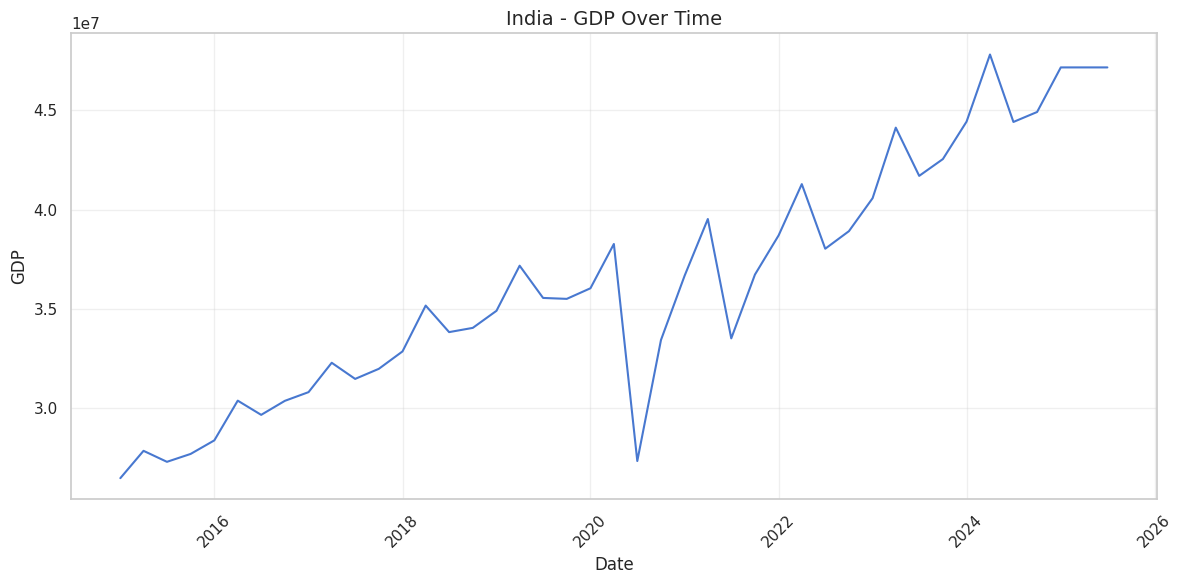

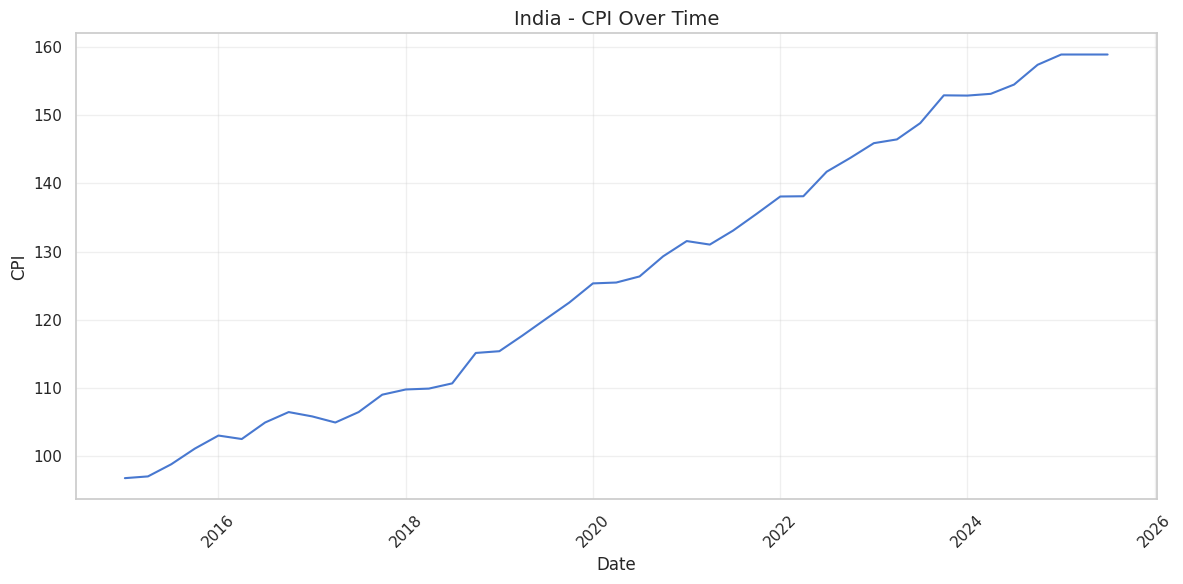

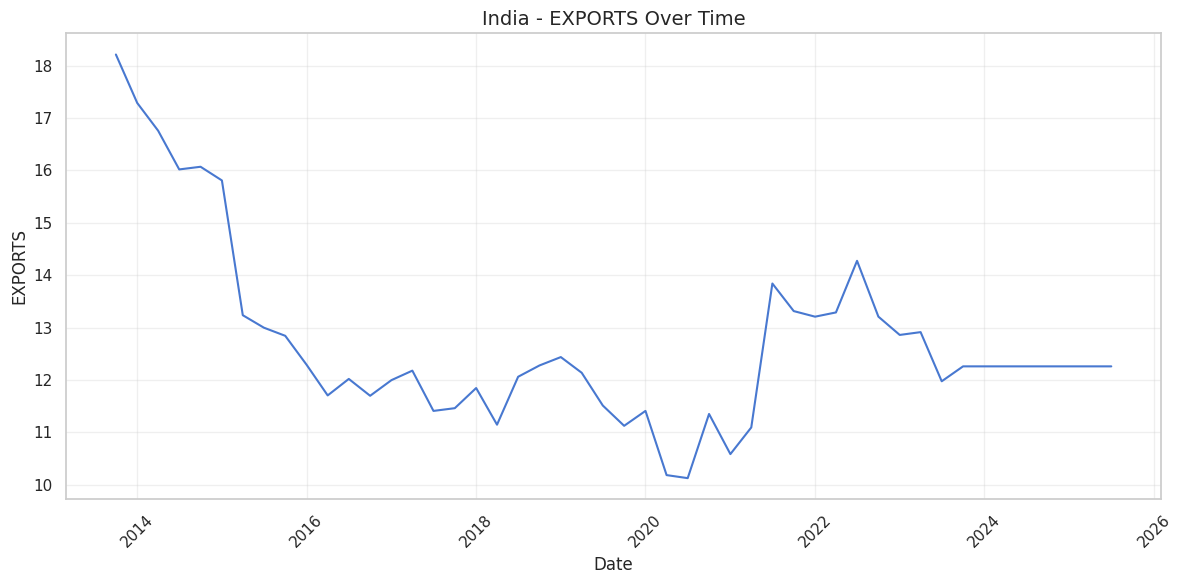


--- Time Series Visualization for South Africa ---


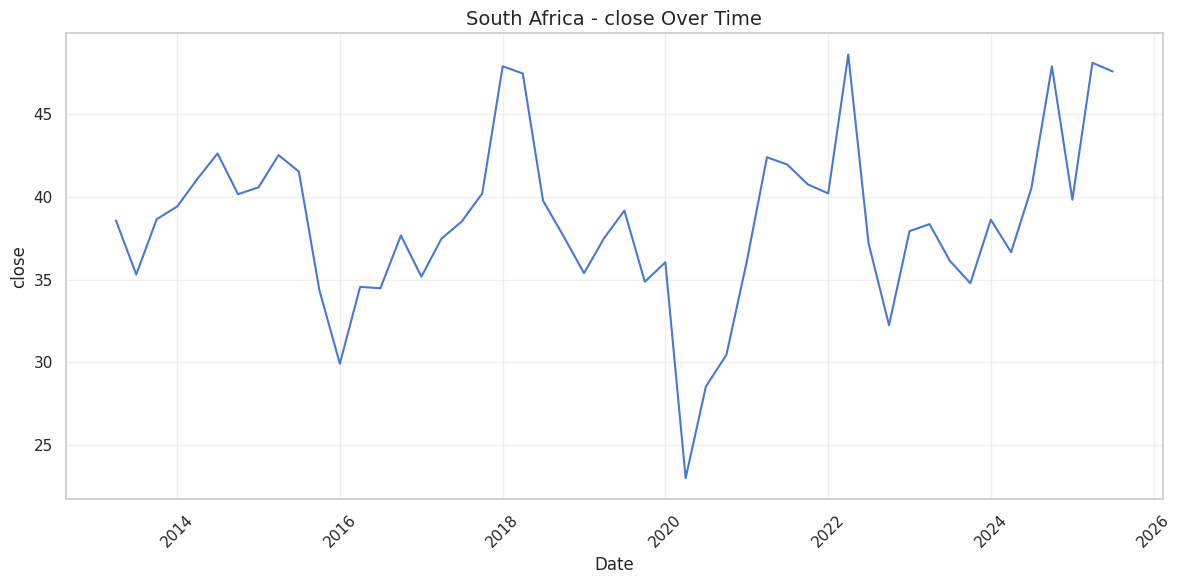

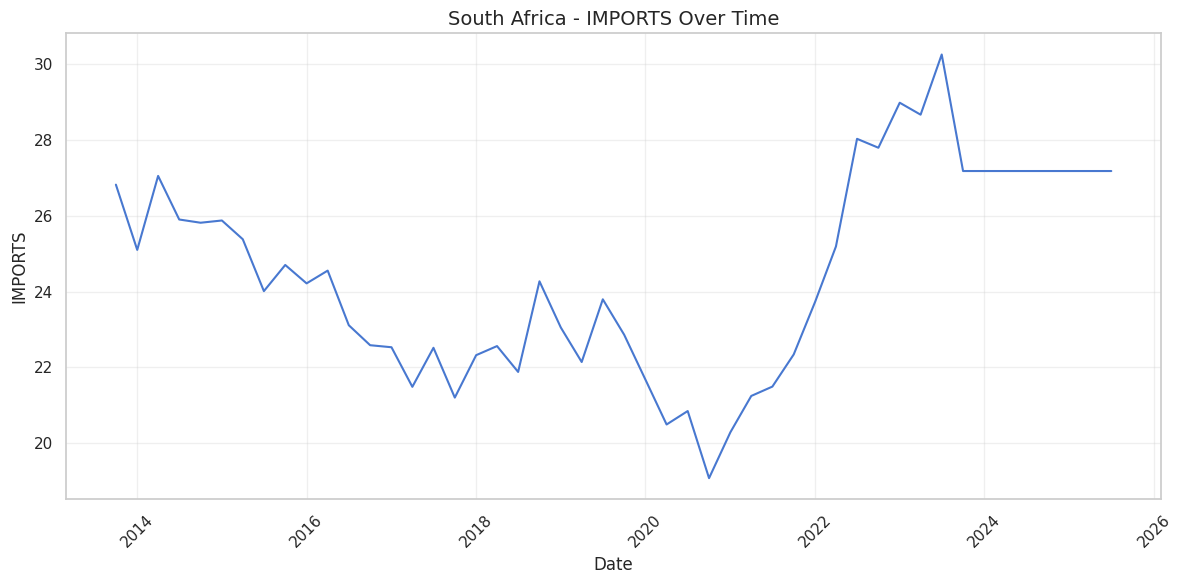

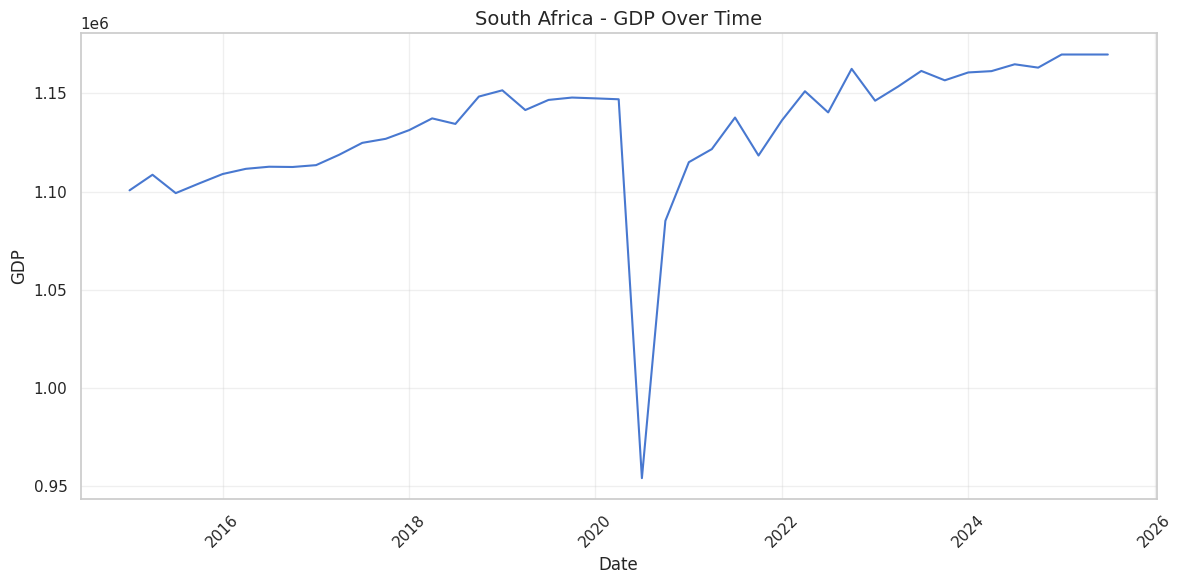

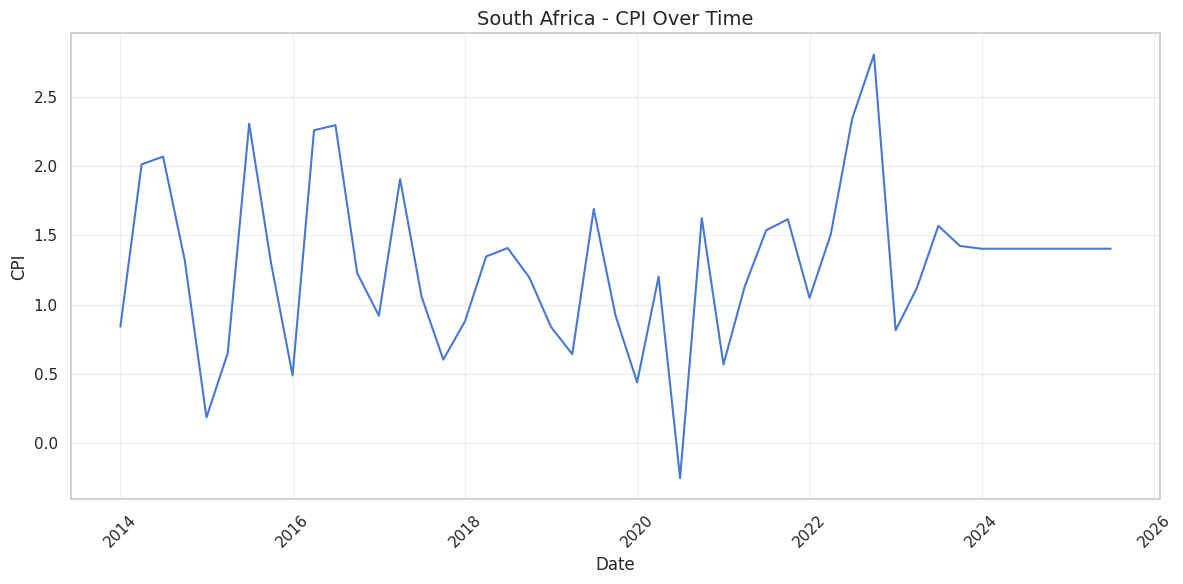

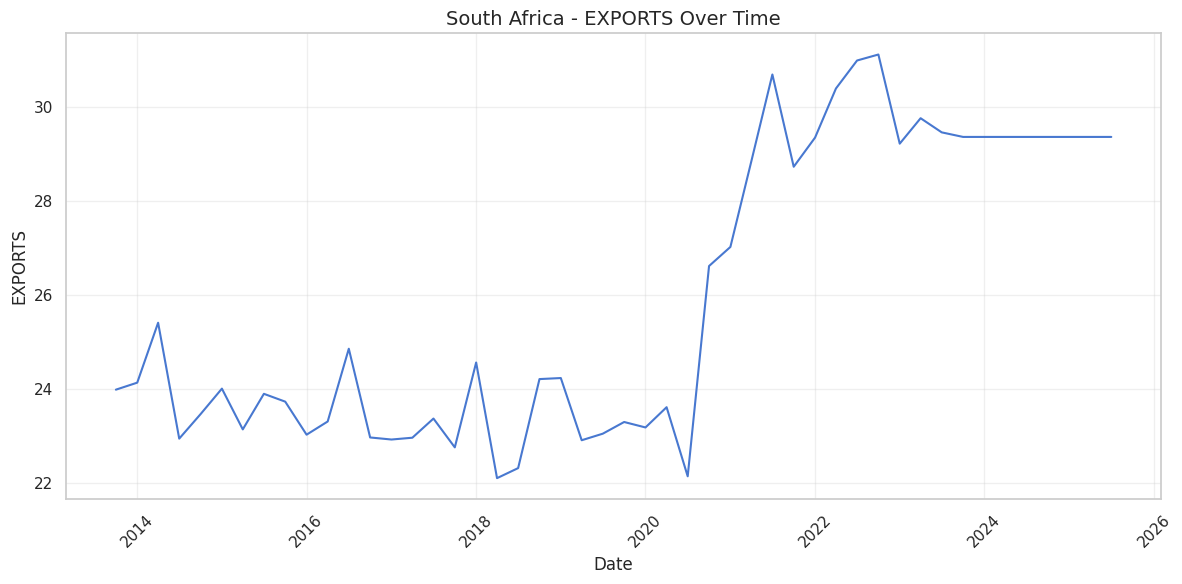

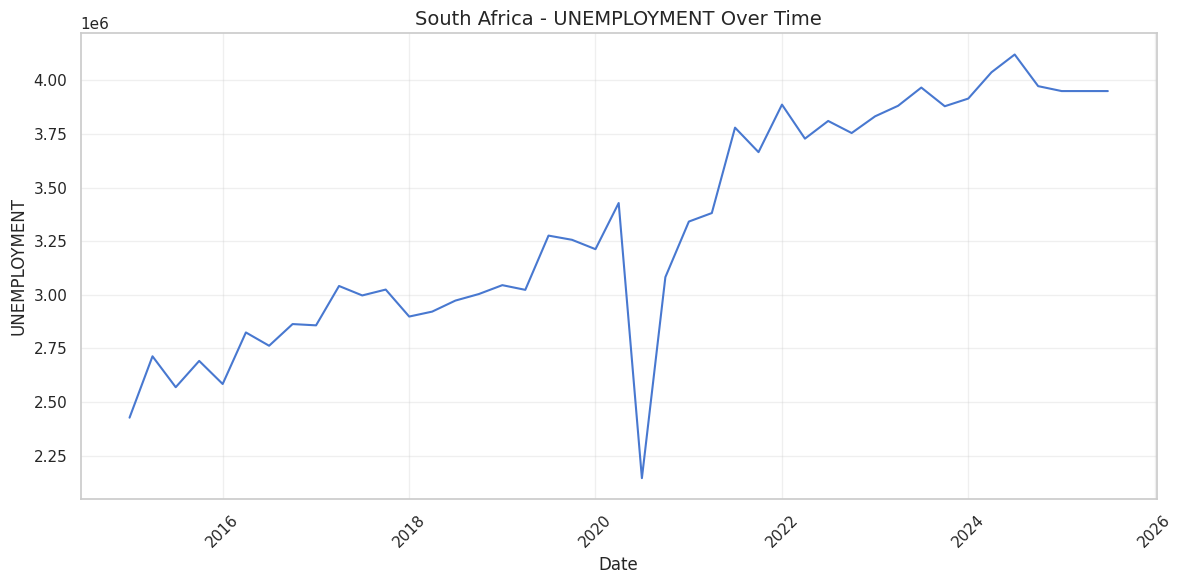

In [51]:
def visualize_time_series(df, country_name):
    """Visualize time series data with improved formatting"""
    print(f"\n--- Time Series Visualization for {country_name} ---")

    # Create a copy of data and ensure numeric values
    plot_data = df.copy()

    # Convert all columns to numeric values explicitly
    for column in plot_data.columns:
        plot_data[column] = pd.to_numeric(plot_data[column], errors='coerce')

    # Make sure data is sorted by date
    plot_data = plot_data.sort_index()

    # Plot time series of each variable with improved formatting
    for column in plot_data.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(plot_data.index, plot_data[column])

        # Improve title and labels
        plt.title(f'{country_name} - {column} Over Time', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(column, fontsize=12)

        # Use fewer ticks with better formatting on y-axis
        if column == 'close':
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(
                lambda x, pos: f'{x/1000:.1f}K' if x >= 1000 else f'{x:.0f}'
            ))
            # Use fewer y-axis ticks
            plt.locator_params(axis='y', nbins=8)

        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Rest of the function for normalized visualization...

# Visualize time series for each country
visualize_time_series(brazil_data, "Brazil")
visualize_time_series(india_data, "India")
visualize_time_series(sa_data, "South Africa")



--- Scatter Plot Analysis for Brazil ---
Error plotting IMPORTS: can only concatenate str (not "float") to str
Error plotting GDP: can only concatenate str (not "float") to str
Error plotting CPI: can only concatenate str (not "float") to str
Error plotting EXPORTS: can only concatenate str (not "float") to str


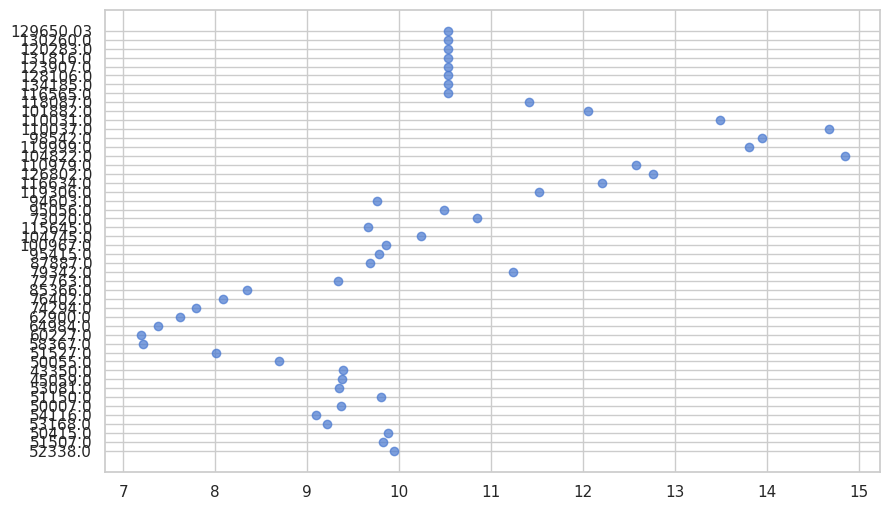

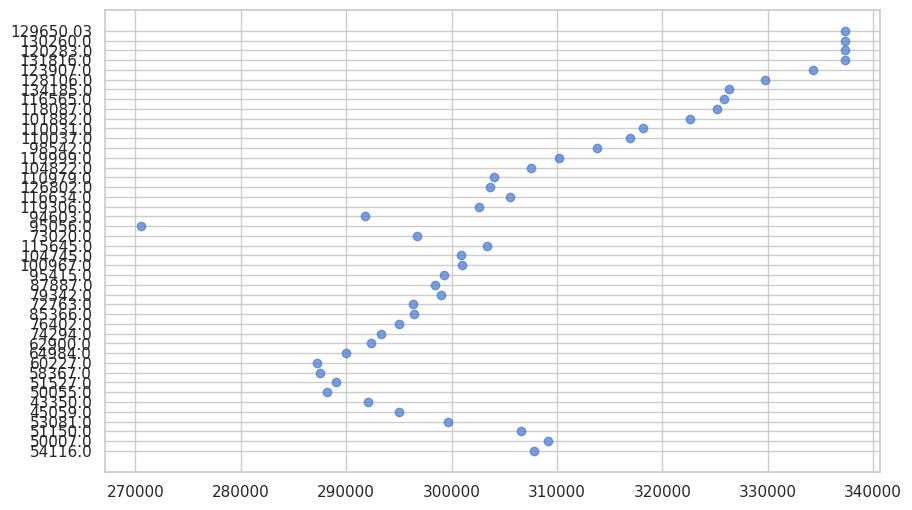

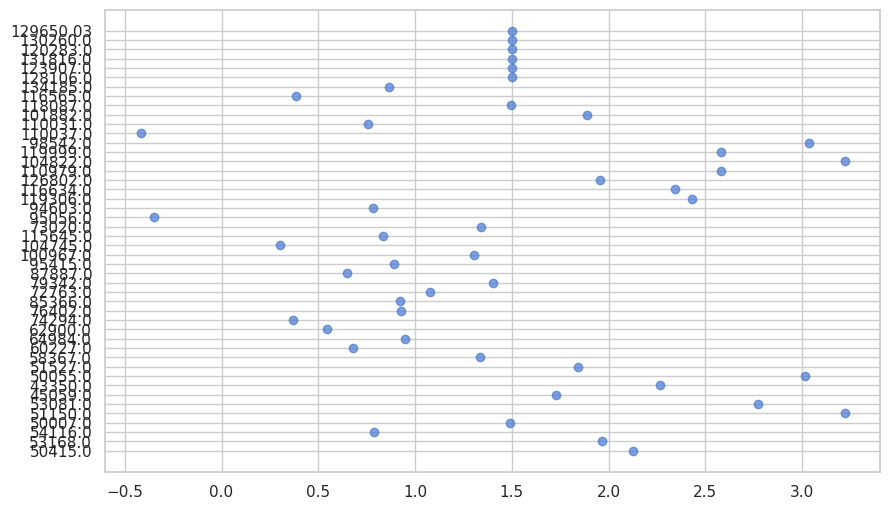

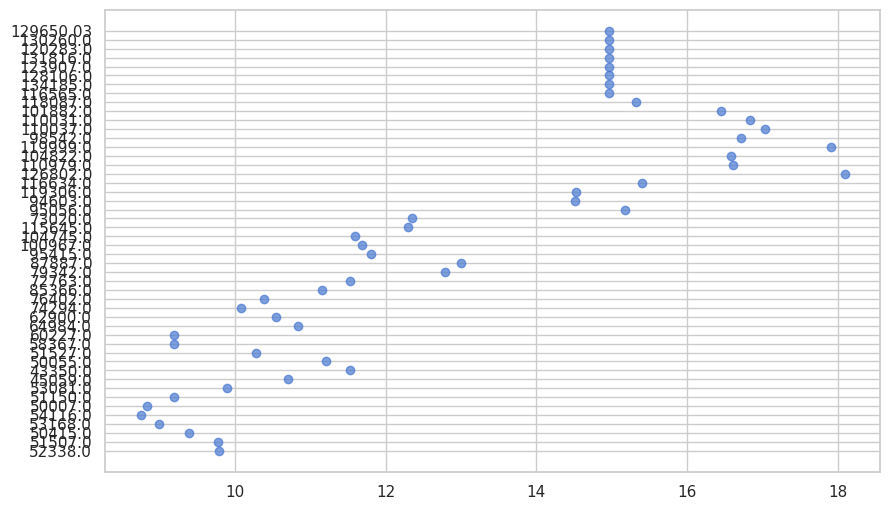

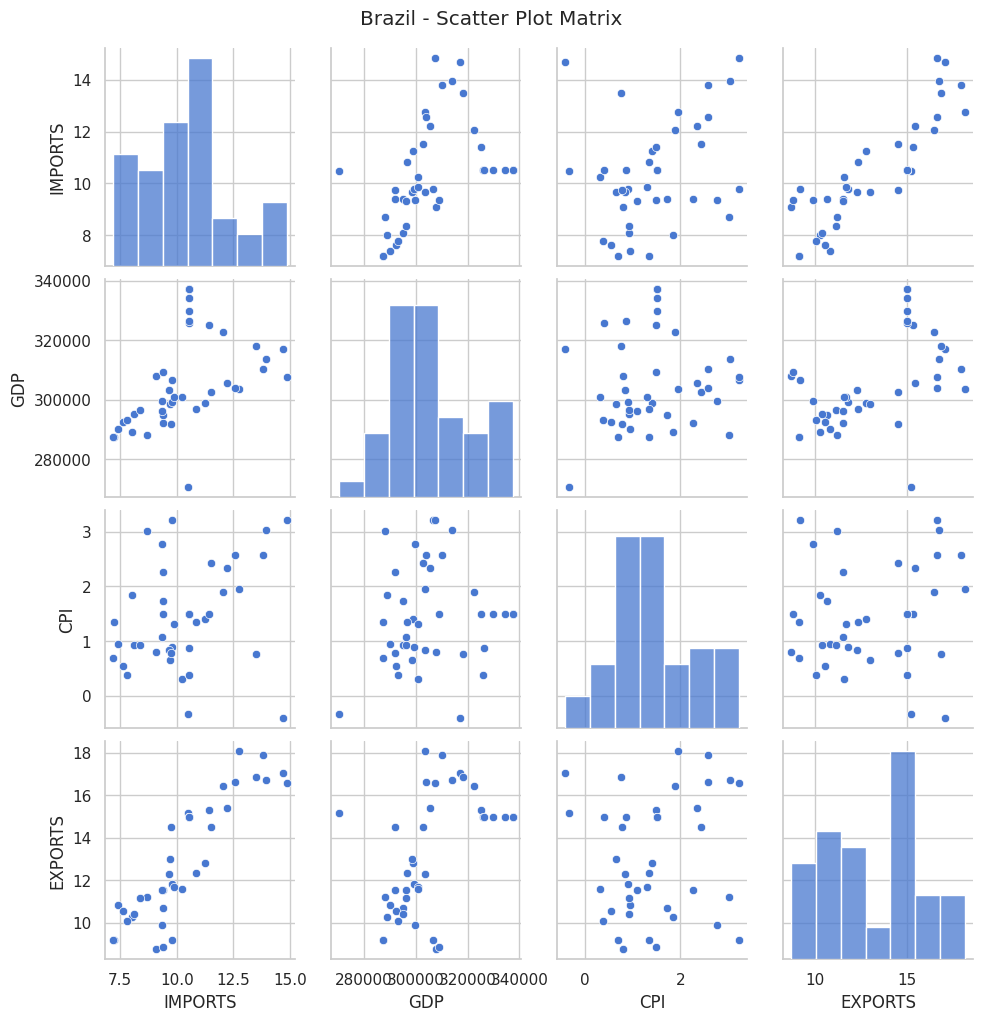


--- Scatter Plot Analysis for India ---
Error plotting IMPORTS: can only concatenate str (not "float") to str
Error plotting GDP: can only concatenate str (not "float") to str
Error plotting CPI: can only concatenate str (not "float") to str
Error plotting EXPORTS: can only concatenate str (not "float") to str


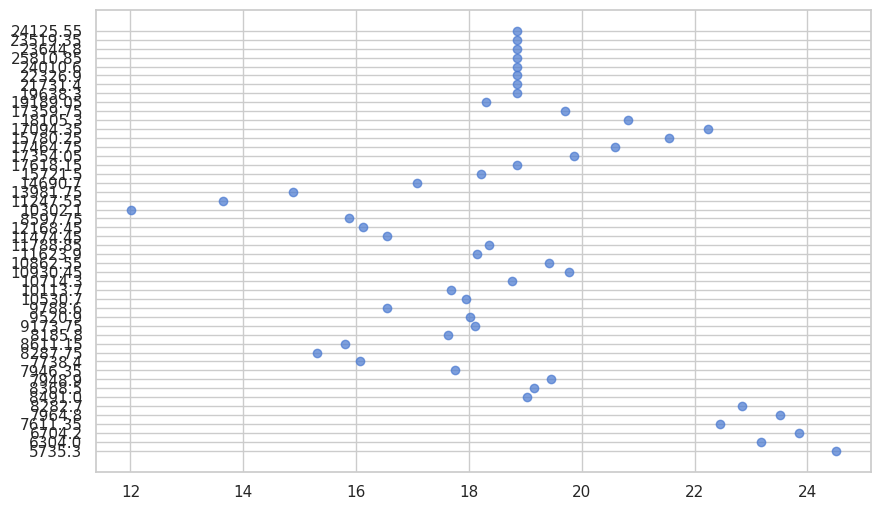

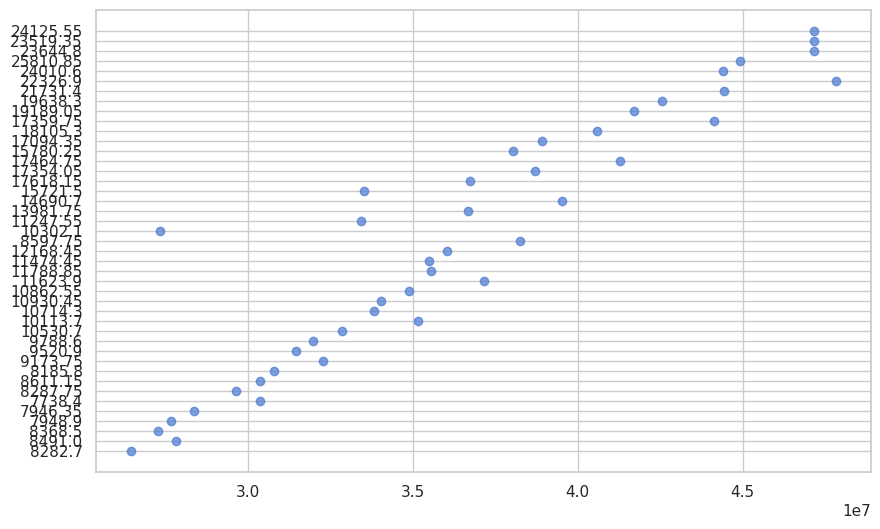

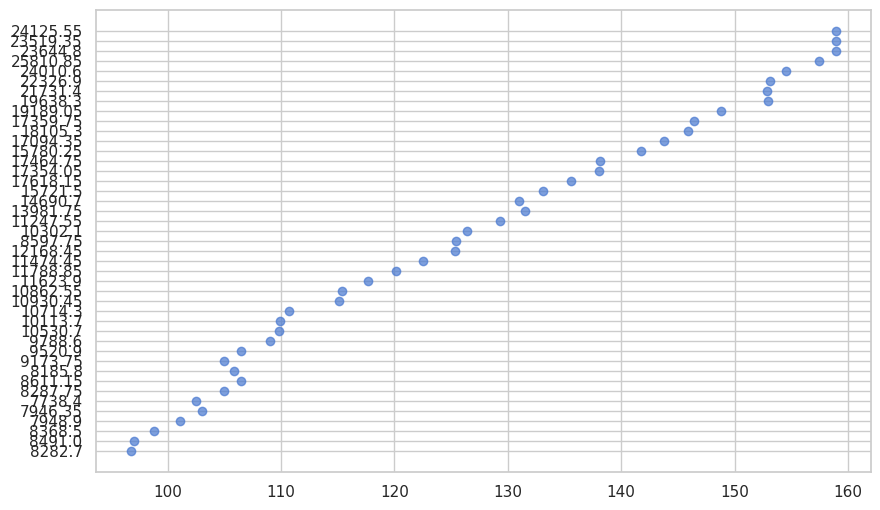

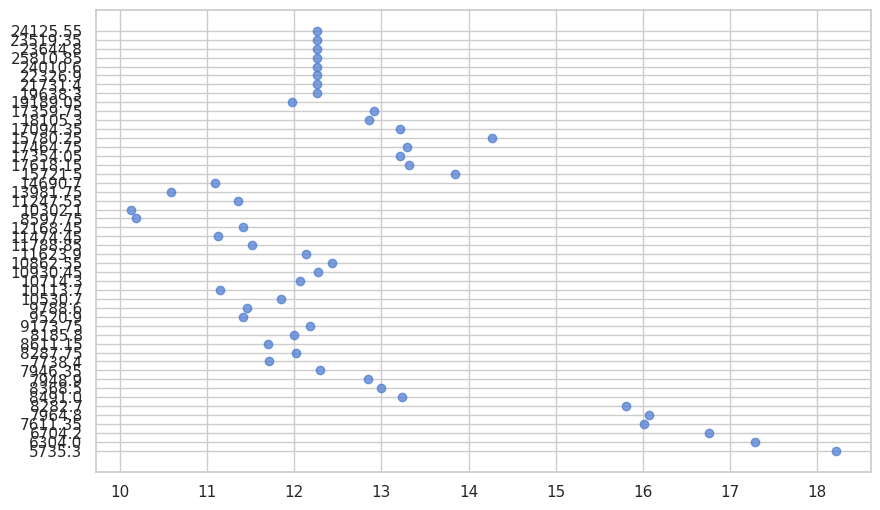

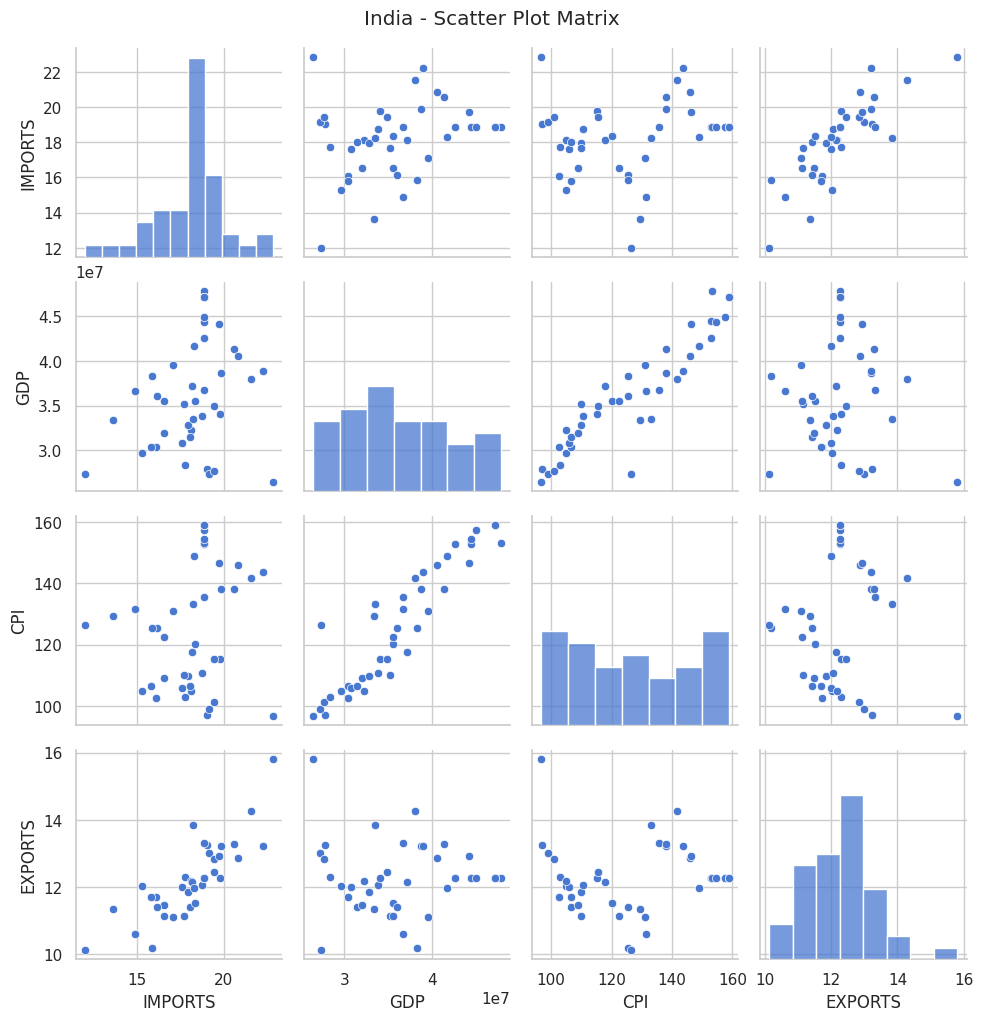


--- Scatter Plot Analysis for South Africa ---
Error plotting IMPORTS: can only concatenate str (not "float") to str
Error plotting GDP: can only concatenate str (not "float") to str
Error plotting CPI: can only concatenate str (not "float") to str
Error plotting EXPORTS: can only concatenate str (not "float") to str
Error plotting UNEMPLOYMENT: can only concatenate str (not "float") to str


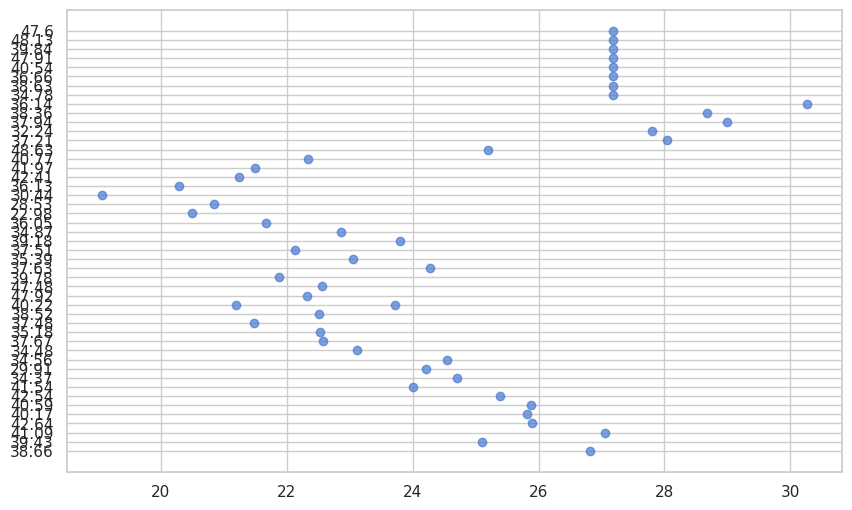

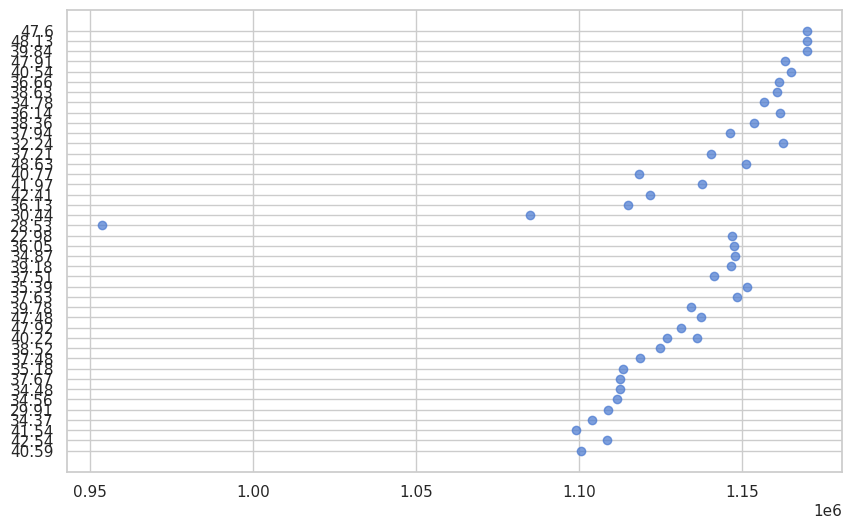

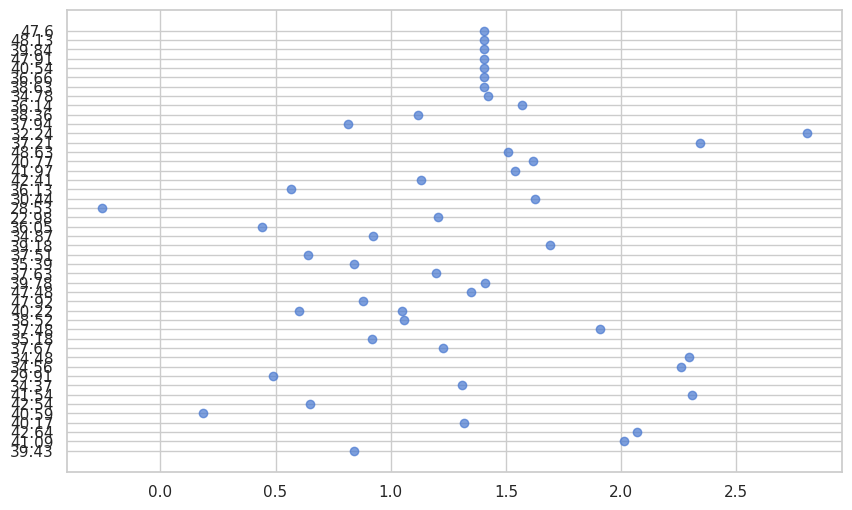

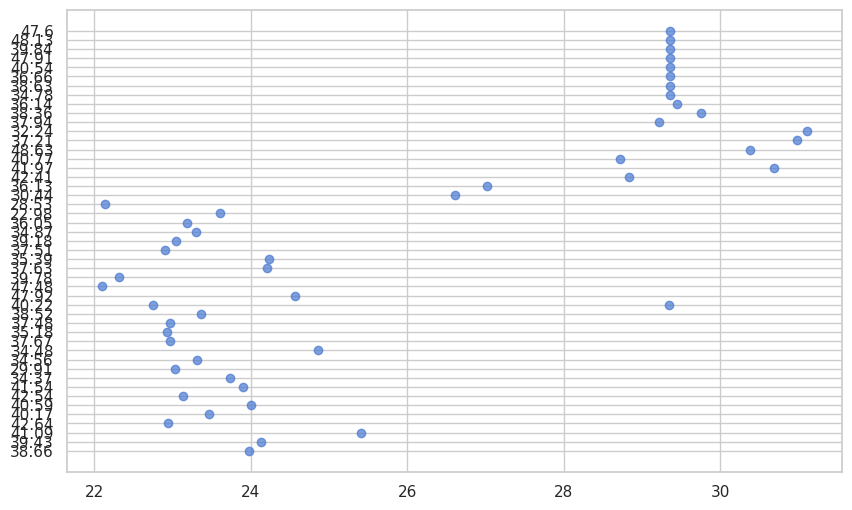

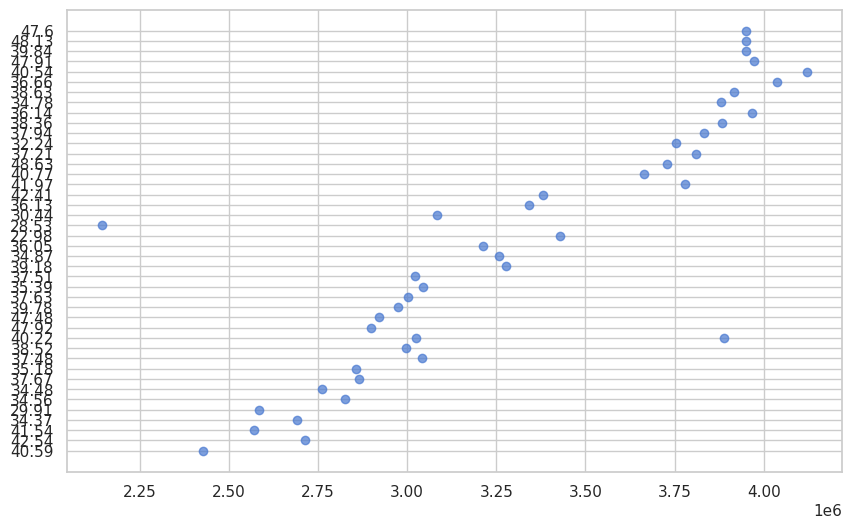

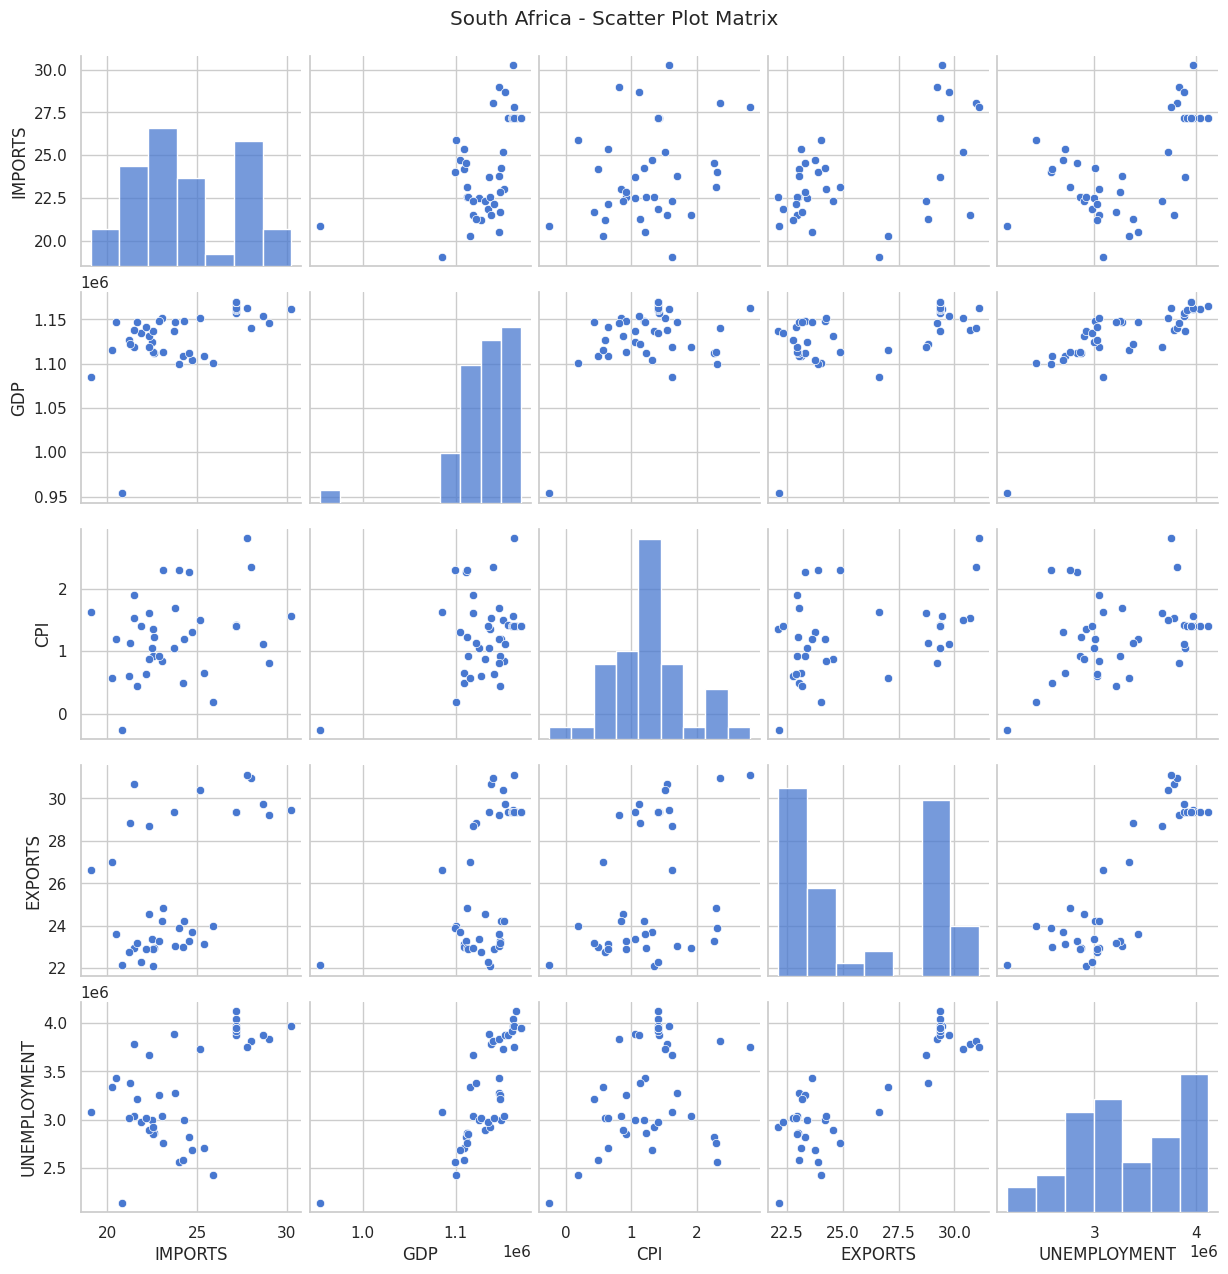

In [46]:
def create_scatter_plots(data, country_name):
    """Create scatter plots between stock price and macro indicators"""
    print(f"\n--- Scatter Plot Analysis for {country_name} ---")

    # First, convert any string columns that should be numeric
    for column in data.columns:
        if column != 'close':
            # Try to convert to numeric, set errors='coerce' to convert non-numeric values to NaN
            data[column] = pd.to_numeric(data[column], errors='coerce')

    # Create scatter plots with trend lines
    for column in data.columns:
        if column != 'close':
            # Skip columns with all NaN values
            if data[column].isna().all():
                print(f"Skipping {column} - contains no numeric data")
                continue

            # Drop NaN values for this specific plot
            plot_data = data[['close', column]].dropna()

            if len(plot_data) < 2:  # Need at least 2 points for a trend line
                print(f"Skipping {column} - insufficient data points after removing NaNs")
                continue

            try:
                plt.figure(figsize=(10, 6))
                plt.scatter(plot_data[column], plot_data['close'], alpha=0.7)

                # Add trend line
                z = np.polyfit(plot_data[column], plot_data['close'], 1)
                p = np.poly1d(z)
                plt.plot(plot_data[column], p(plot_data[column]), "r--", alpha=0.7)

                plt.title(f'{country_name} - Stock Price vs {column}')
                plt.xlabel(column)
                plt.ylabel('Stock Price (close)')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {str(e)}")

    # For the pairplot, use only numeric columns with sufficient non-NaN values
    numeric_cols = ['close']
    for col in data.columns:
        if col != 'close' and not data[col].isna().all() and data[col].count() > 5:
            numeric_cols.append(col)

    if len(numeric_cols) > 1:
        sns.pairplot(data[numeric_cols].dropna(), height=2.5)
        plt.suptitle(f'{country_name} - Scatter Plot Matrix', y=1.02)
        plt.show()
    else:
        print("Not enough valid numeric columns for pairplot")

# For Brazil
create_scatter_plots(brazil_data, "Brazil")

# For India
create_scatter_plots(india_data, "India")

# For South Africa
create_scatter_plots(sa_data, "South Africa")


--- Rolling Correlation Analysis for Brazil ---
  Column IMPORTS type: float64
  Column GDP type: float64
  Column CPI type: float64
  Column EXPORTS type: float64
  Successfully calculated rolling correlation for IMPORTS
  Successfully calculated rolling correlation for GDP
  Successfully calculated rolling correlation for CPI
  Successfully calculated rolling correlation for EXPORTS


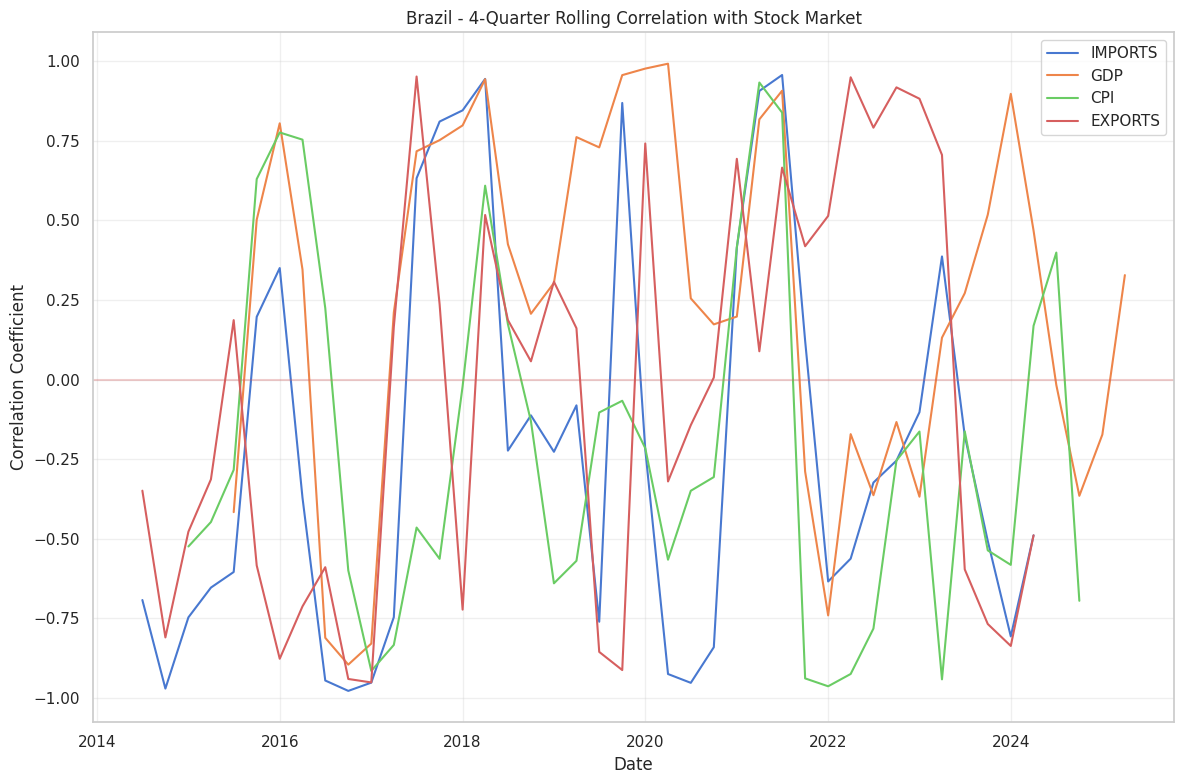


--- Rolling Correlation Analysis for India ---
  Column IMPORTS type: float64
  Column GDP type: float64
  Column CPI type: float64
  Column EXPORTS type: float64
  Successfully calculated rolling correlation for IMPORTS
  Successfully calculated rolling correlation for GDP
  Successfully calculated rolling correlation for CPI
  Successfully calculated rolling correlation for EXPORTS


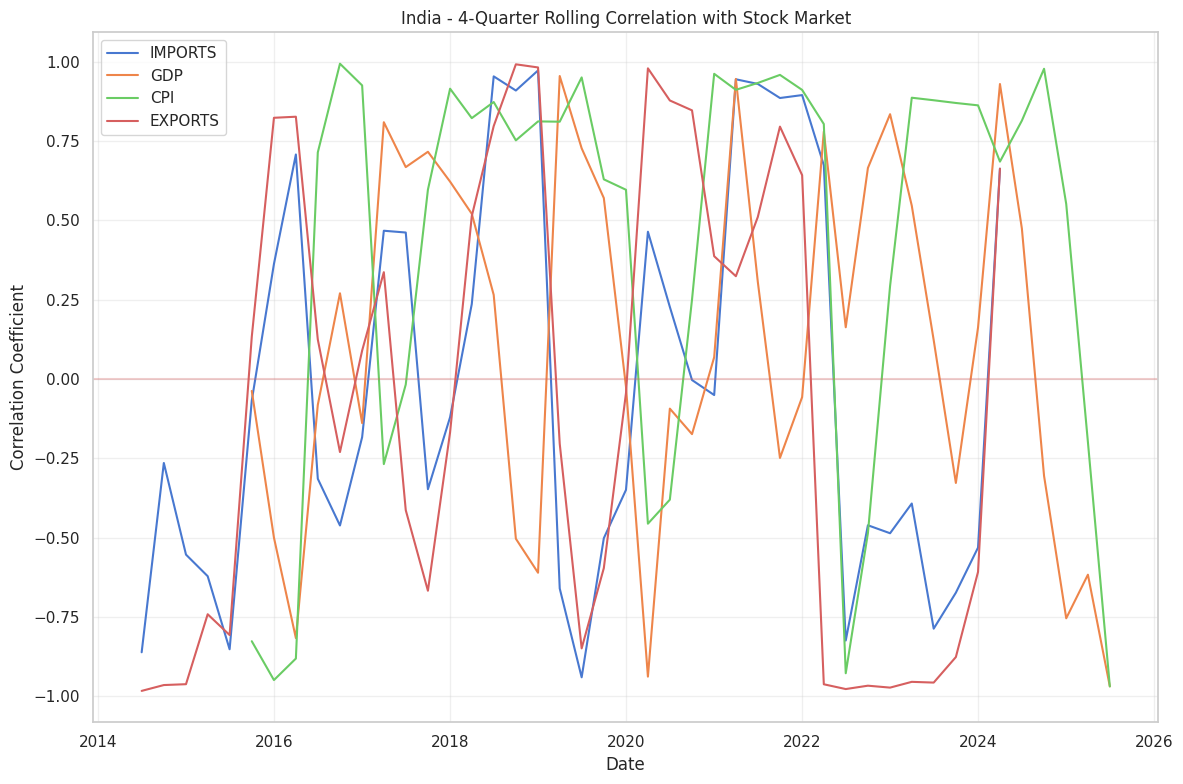


--- Rolling Correlation Analysis for South Africa ---
  Column IMPORTS type: float64
  Column GDP type: float64
  Column CPI type: float64
  Column EXPORTS type: float64
  Column UNEMPLOYMENT type: float64
  Successfully calculated rolling correlation for IMPORTS
  Successfully calculated rolling correlation for GDP
  Successfully calculated rolling correlation for CPI
  Successfully calculated rolling correlation for EXPORTS
  Successfully calculated rolling correlation for UNEMPLOYMENT


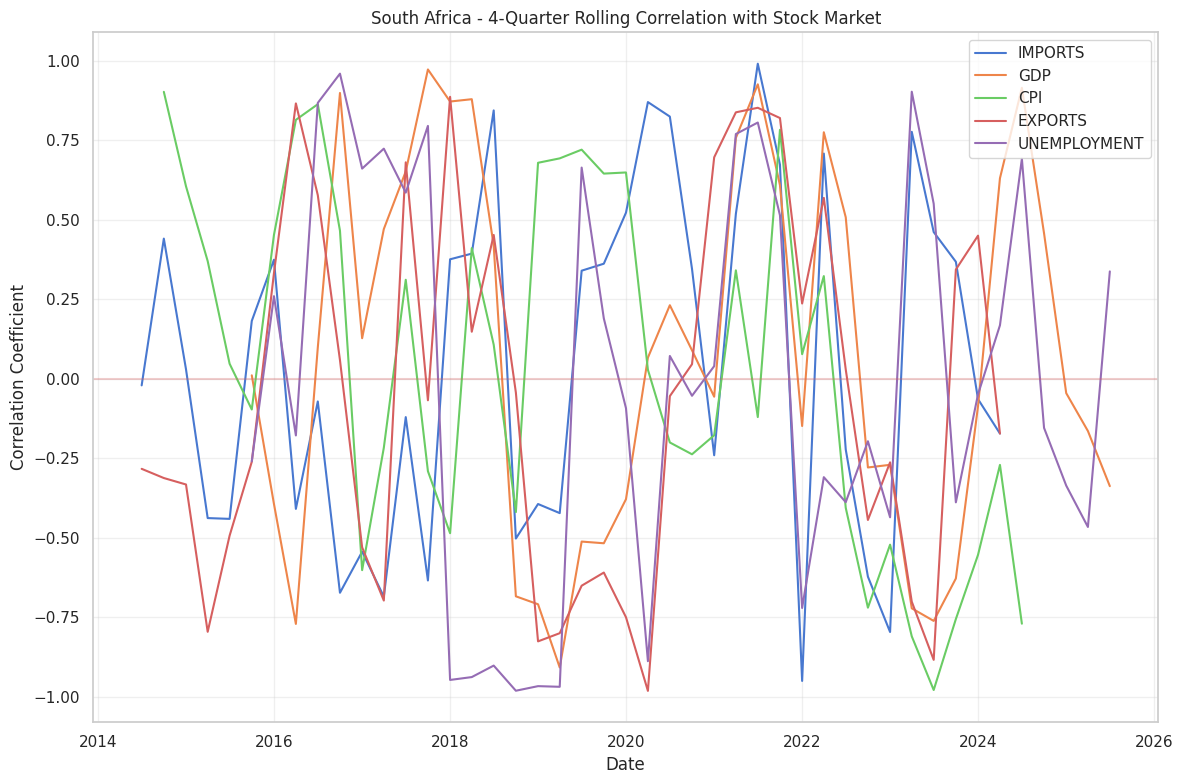

In [52]:
def plot_rolling_correlation(rolling_corr, country, window):
    """
    Create improved rolling correlation visualization with better formatting,
    reduced clutter, and clearer insights.
    """
    # Create figure with appropriate size
    plt.figure(figsize=(14, 8))

    # Custom color palette for better differentiation
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    line_styles = ['-', '--', '-.', ':']

    # Plot each indicator with improved styling
    for i, column in enumerate(rolling_corr.columns):
        plt.plot(
            rolling_corr.index,
            rolling_corr[column],
            label=column,
            color=colors[i % len(colors)],
            linestyle=line_styles[i % len(line_styles)],
            linewidth=2.5
        )

    # Reduce y-axis tick marks to 5 evenly spaced values
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.ylim(-1.1, 1.1)  # Standard range for correlation

    # Add shading for correlation significance regions
    plt.axhspan(0.7, 1.1, color='green', alpha=0.1, label='Strong Positive')
    plt.axhspan(-1.1, -0.7, color='red', alpha=0.1, label='Strong Negative')
    plt.axhspan(-0.3, 0.3, color='gray', alpha=0.1, label='Weak/No Correlation')

    # Add reference line at zero
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

    # Format x-axis for better readability
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)

    # Add title with improved formatting
    plt.title(f'{country} - {window}-Quarter Rolling Correlation with Stock Market',
              fontsize=16, fontweight='bold')

    # Move legend to the right side of the chart for better visibility
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True,
               framealpha=0.8, fontsize=10)

    # Improve grid appearance
    plt.grid(True, alpha=0.15, linestyle='--')

    # Add annotations for economic events (example)
    if country == "Brazil" and '2020-03-31' in rolling_corr.index:
        event_date = pd.Timestamp('2020-03-31')
        plt.annotate('COVID-19',
                     xy=(event_date, 0),
                     xytext=(event_date, -0.8),
                     arrowprops=dict(arrowstyle='->'),
                     fontsize=10)

    plt.tight_layout()
    plt.show()

    # Create a secondary chart with panels for clearer individual trends
    indicators = len(rolling_corr.columns)
    if indicators > 1:
        fig, axes = plt.subplots(indicators, 1, figsize=(14, 3*indicators), sharex=True)
        fig.suptitle(f'{country} - Individual {window}-Quarter Rolling Correlations',
                    fontsize=16, y=0.98)

        for i, column in enumerate(rolling_corr.columns):
            # Plot on individual subplot
            axes[i].plot(rolling_corr.index, rolling_corr[column],
                        color=colors[i % len(colors)], linewidth=2.5)

            # Add indicator name as label
            axes[i].set_ylabel(column, fontsize=10)

            # Add zero reference line
            axes[i].axhline(y=0, color='r', linestyle='-', alpha=0.3)

            # Add shading for correlation interpretation
            axes[i].axhspan(0.7, 1.1, color='green', alpha=0.1)
            axes[i].axhspan(-1.1, -0.7, color='red', alpha=0.1)

            # Set consistent y-axis limits
            axes[i].set_ylim(-1.1, 1.1)
            axes[i].set_yticks([-1, -0.5, 0, 0.5, 1])

            # Format grid
            axes[i].grid(True, alpha=0.15, linestyle='--')

            # Show correlation range
            min_corr = rolling_corr[column].min()
            max_corr = rolling_corr[column].max()
            axes[i].annotate(f"Range: [{min_corr:.2f}, {max_corr:.2f}]",
                           xy=(0.02, 0.05), xycoords='axes fraction')

        # Format x-axis on bottom subplot only
        axes[-1].set_xlabel('Date', fontsize=12)
        axes[-1].tick_params(rotation=45)

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Make room for suptitle
        plt.show()


# Analyze rolling correlations for each country
window_size = 4
brazil_rolling = analyze_rolling_correlation(brazil_data, "Brazil", window=window_size)
india_rolling = analyze_rolling_correlation(india_data, "India", window=window_size)
sa_rolling = analyze_rolling_correlation(sa_data, "South Africa", window=window_size)




--- Cross-Country Comparison ---


<Figure size 1200x800 with 0 Axes>

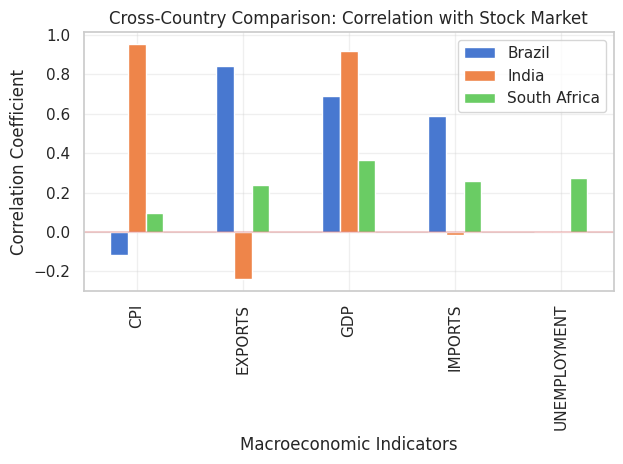


Comparison of correlations with stock market:
                Brazil     India  South Africa
CPI          -0.117718  0.953000      0.096890
EXPORTS       0.843928 -0.238416      0.238773
GDP           0.690812  0.919395      0.363132
IMPORTS       0.589875 -0.017329      0.256782
UNEMPLOYMENT       NaN       NaN      0.276043


In [48]:
def compare_countries(brazil_corr, india_corr, sa_corr):
    """Compare correlation patterns across countries"""
    print("\n--- Cross-Country Comparison ---")

    # Extract correlations with stock market
    comparison = pd.DataFrame({
        'Brazil': brazil_corr['close'].drop('close'),
        'India': india_corr['close'].drop('close'),
        'South Africa': sa_corr['close'].drop('close')
    })

    # Plot comparison
    plt.figure(figsize=(12, 8))
    comparison.plot(kind='bar')
    plt.title('Cross-Country Comparison: Correlation with Stock Market')
    plt.xlabel('Macroeconomic Indicators')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print comparison table
    print("\nComparison of correlations with stock market:")
    print(comparison)

    return comparison

# Compare correlation patterns across countries
country_comparison = compare_countries(brazil_corr, india_corr, sa_corr)



In [49]:
def save_results(brazil_data, india_data, sa_data, brazil_corr, india_corr, sa_corr):
    """Save cleaned data and analysis results"""
    print("\n--- Saving Results ---")

    # Create output directory in Google Drive
    output_dir = '/content/drive/MyDrive/analysis_results'
    os.makedirs(output_dir, exist_ok=True)

    # Save cleaned data
    brazil_data.to_csv(f'{output_dir}/brazil_cleaned.csv')
    india_data.to_csv(f'{output_dir}/india_cleaned.csv')
    sa_data.to_csv(f'{output_dir}/sa_cleaned.csv')

    # Save correlation matrices
    brazil_corr.to_csv(f'{output_dir}/brazil_correlation.csv')
    india_corr.to_csv(f'{output_dir}/india_correlation.csv')
    sa_corr.to_csv(f'{output_dir}/sa_correlation.csv')

    # Save cross-country comparison
    country_comparison.to_csv(f'{output_dir}/country_comparison.csv')

    print(f"All results saved to {output_dir}")

# Save results
save_results(brazil_data, india_data, sa_data, brazil_corr, india_corr, sa_corr)




--- Saving Results ---
All results saved to /content/drive/MyDrive/analysis_results


In [53]:
def summarize_findings(brazil_stock_corr, india_stock_corr, sa_stock_corr):
    """Summarize key findings from the analysis"""
    print("\n--- Key Insights and Findings ---")

    for country, stock_corr in [
        ("Brazil", brazil_stock_corr),
        ("India", india_stock_corr),
        ("South Africa", sa_stock_corr)
    ]:
        print(f"\n{country}:")

        # Strongest positive correlation
        pos_corr = stock_corr.drop('close').nlargest(1)
        print(f"  • Strongest positive correlation: {pos_corr.index[0]} ({pos_corr.values[0]:.2f})")

        # Strongest negative correlation (if any)
        neg_corr = stock_corr.drop('close')[stock_corr.drop('close') < 0].nlargest(1)
        if not neg_corr.empty:
            print(f"  • Strongest negative correlation: {neg_corr.index[0]} ({neg_corr.values[0]:.2f})")
        else:
            print("  • No significant negative correlations found")

    # Cross-country insights
    print("\nCross-Country Insights:")
    for indicator in country_comparison.index:
        values = country_comparison.loc[indicator]
        if max(values) - min(values) > 0.5:
            print(f"  • {indicator} shows diverse correlation patterns across countries:")
            for country in country_comparison.columns:
                print(f"    - {country}: {country_comparison.loc[indicator, country]:.2f}")

# Summarize findings
summarize_findings(brazil_stock_corr, india_stock_corr, sa_stock_corr)



--- Key Insights and Findings ---

Brazil:
  • Strongest positive correlation: EXPORTS (0.84)
  • Strongest negative correlation: CPI (-0.12)

India:
  • Strongest positive correlation: CPI (0.95)
  • Strongest negative correlation: IMPORTS (-0.02)

South Africa:
  • Strongest positive correlation: GDP (0.36)
  • No significant negative correlations found

Cross-Country Insights:
  • CPI shows diverse correlation patterns across countries:
    - Brazil: -0.12
    - India: 0.95
    - South Africa: 0.10
  • EXPORTS shows diverse correlation patterns across countries:
    - Brazil: 0.84
    - India: -0.24
    - South Africa: 0.24
  • GDP shows diverse correlation patterns across countries:
    - Brazil: 0.69
    - India: 0.92
    - South Africa: 0.36
  • IMPORTS shows diverse correlation patterns across countries:
    - Brazil: 0.59
    - India: -0.02
    - South Africa: 0.26
